In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

pd.set_option('display.float_format', '{:.2f}'.format)

In [2]:
df_data_general = pd.read_csv('../../../data/data_general_2.csv')

df_data_general['INITIAL_TIME'] = pd.to_datetime(df_data_general['INITIAL_TIME'])
df_data_general['FINAL_TIME'] = pd.to_datetime(df_data_general['FINAL_TIME'])

df_data_general['INITIAL_TIME'] = df_data_general['INITIAL_TIME'].dt.to_period('D')
df_data_general['INITIAL_TIME'] = df_data_general['INITIAL_TIME'].dt.to_timestamp()


df_data_general['FINAL_TIME'] = df_data_general['FINAL_TIME'].dt.to_period('D')
df_data_general['FINAL_TIME'] = df_data_general['FINAL_TIME'].dt.to_timestamp()

df_data_general['Weekday']= df_data_general['INITIAL_TIME'].dt.strftime('%A')
df_data_general['number_of_day'] = df_data_general['INITIAL_TIME'].dt.day_of_week

df_data_general['TIME_ON_DEVICE_MIN'] = df_data_general['TIME_ON_DEVICE_SEC'] / 60

df_data_general['Hour'] = df_data_general['INITIAL_TIME'].dt.hour
df_data_general['Weekday'] = df_data_general['INITIAL_TIME'].dt.weekday   # 0=Lunes, 6=Domingo
df_data_general['Weekend'] = (df_data_general['Weekday'] >= 5).astype(int)
df_data_general['Month'] = df_data_general['INITIAL_TIME'].dt.month

df_data_general = df_data_general[df_data_general['TIME_ON_DEVICE_MIN'] < 600 ]

df_data_general = df_data_general[df_data_general['WIN_TOTAL'] > 0]
df_data_general['NET_SPEND'] = df_data_general['FINAL_AMOUNT'] - df_data_general['INITIAL_AMOUNT']
df_data_general = df_data_general[df_data_general['NET_SPEND'] < 10000 ]

In [3]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import joblib  # Para guardar scalers y otros objetos
import warnings
warnings.filterwarnings('ignore')

class CasinoMLPModel:
    def __init__(self):
        self.scalers = {}
        self.models = {}
        self.pca_models = {}
        
    def create_business_features(self, df, tiempo_pred=None, bet_pred=None):
        """
        Crear features que reflejen la lógica real del negocio de casino
        """
        features = df[['INITIAL_AMOUNT', 'AVG_BET', 'Cluster']].copy()
        
        if tiempo_pred is not None:
            features['tiempo_pred'] = tiempo_pred
            
        if bet_pred is not None:
            features['bet_pred'] = bet_pred
            features['total_money_handled'] = bet_pred
            features['house_edge_effect'] = bet_pred * 0.05
            features['money_multiplier'] = bet_pred / (df['INITIAL_AMOUNT'] + 1)
            features['reinvestment_indicator'] = np.where(bet_pred > df['INITIAL_AMOUNT'], 1, 0)
            features['excess_betting'] = np.maximum(0, bet_pred - df['INITIAL_AMOUNT'])
            features['money_at_risk'] = np.minimum(bet_pred, df['INITIAL_AMOUNT'])
            features['cluster_risk_adjusted'] = df['Cluster'] * features['money_multiplier']
            
        return features
    
    def create_mlp_model(self, input_shape, model_type='tiempo'):
        """Crear modelo MLP optimizado"""
        model = keras.Sequential()
        
        if model_type == 'tiempo':
            model.add(layers.Dense(128, activation='relu', input_shape=(input_shape,)))
            model.add(layers.BatchNormalization())
            model.add(layers.Dropout(0.3))
            model.add(layers.Dense(64, activation='relu'))
            model.add(layers.BatchNormalization())
            model.add(layers.Dropout(0.2))
            model.add(layers.Dense(32, activation='relu'))
            model.add(layers.Dropout(0.1))
            model.add(layers.Dense(1, activation='linear'))
            
        elif model_type == 'bet':
            model.add(layers.Dense(256, activation='relu', input_shape=(input_shape,)))
            model.add(layers.BatchNormalization())
            model.add(layers.Dropout(0.4))
            model.add(layers.Dense(128, activation='relu'))
            model.add(layers.BatchNormalization())
            model.add(layers.Dropout(0.3))
            model.add(layers.Dense(64, activation='relu'))
            model.add(layers.BatchNormalization())
            model.add(layers.Dropout(0.2))
            model.add(layers.Dense(32, activation='relu'))
            model.add(layers.Dropout(0.1))
            model.add(layers.Dense(1, activation='linear'))
            
        elif model_type == 'win':
            model.add(layers.Dense(512, activation='relu', input_shape=(input_shape,)))
            model.add(layers.BatchNormalization())
            model.add(layers.Dropout(0.4))
            model.add(layers.Dense(256, activation='relu'))
            model.add(layers.BatchNormalization())
            model.add(layers.Dropout(0.3))
            model.add(layers.Dense(128, activation='relu'))
            model.add(layers.BatchNormalization())
            model.add(layers.Dropout(0.3))
            model.add(layers.Dense(64, activation='relu'))
            model.add(layers.BatchNormalization())
            model.add(layers.Dropout(0.2))
            model.add(layers.Dense(32, activation='relu'))
            model.add(layers.Dropout(0.1))
            model.add(layers.Dense(1, activation='linear'))
        
        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=0.001),
            loss='mse',
            metrics=['mae']
        )
        
        return model
    
    def generate_random_data(self, X_train, n_samples=1000):
        """
        Generar datos aleatorios basados en las estadísticas de los datos de entrenamiento
        """
        np.random.seed(42)  # Para reproducibilidad
        
        random_data = np.zeros((n_samples, X_train.shape[1]))
        
        for i in range(X_train.shape[1]):
            # Generar datos basados en min, max y distribución de cada feature
            feature_min = X_train[:, i].min()
            feature_max = X_train[:, i].max()
            feature_mean = X_train[:, i].mean()
            feature_std = X_train[:, i].std()
            
            # Usar distribución normal truncada para generar datos más realistas
            random_data[:, i] = np.random.normal(feature_mean, feature_std, n_samples)
            
            # Asegurar que estén en el rango válido
            random_data[:, i] = np.clip(random_data[:, i], feature_min, feature_max)
        
        return random_data
    
    def create_pca_visualization(self, X_real, y_real, X_random, y_pred_random, 
                                model_name, output_dir='visualizations'):
        """
        Crear visualización con PCA de 1 componente
        """
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        
        # Combinar datos reales y aleatorios para PCA conjunto
        X_combined = np.vstack([X_real, X_random])
        
        # Aplicar PCA con 1 componente
        pca = PCA(n_components=1)
        X_pca = pca.fit_transform(X_combined)
        
        # Separar componentes PCA
        X_real_pca = X_pca[:len(X_real)]
        X_random_pca = X_pca[len(X_real):]
        
        # Crear DataFrame para seaborn
        df_viz = pd.DataFrame({
            'PCA_Component': np.concatenate([X_real_pca.flatten(), X_random_pca.flatten()]),
            'Predictions': np.concatenate([y_real, y_pred_random]),
            'Data_Type': ['Real'] * len(X_real_pca) + ['Random'] * len(X_random_pca)
        })
        
        # Crear la visualización
        plt.figure(figsize=(12, 8))
        
        # Scatter plot con hue
        sns.scatterplot(data=df_viz, x='PCA_Component', y='Predictions', 
                       hue='Data_Type', alpha=0.7, s=50)
        
        # Líneas de tendencia para cada grupo
        for data_type, color in zip(['Real', 'Random'], ['blue', 'red']):
            subset = df_viz[df_viz['Data_Type'] == data_type]
            if len(subset) > 1:
                # Ajustar línea de tendencia
                lr = LinearRegression()
                X_trend = subset['PCA_Component'].values.reshape(-1, 1)
                y_trend = subset['Predictions'].values
                lr.fit(X_trend, y_trend)
                
                # Crear puntos para la línea
                x_line = np.linspace(subset['PCA_Component'].min(), 
                                   subset['PCA_Component'].max(), 100)
                y_line = lr.predict(x_line.reshape(-1, 1))
                
                # Calcular R² para esta línea
                r2 = lr.score(X_trend, y_trend)
                
                plt.plot(x_line, y_line, color=color, linestyle='--', 
                        alpha=0.8, linewidth=2, 
                        label=f'{data_type} Trend (R²={r2:.3f})')
        
        plt.title(f'Visualización PCA - Modelo {model_name.upper()}\n'
                 f'Componente explicado: {pca.explained_variance_ratio_[0]:.1%} de la varianza')
        plt.xlabel('Componente Principal (PCA)')
        plt.ylabel('Predicciones del Modelo')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Guardar gráfico
        plt.tight_layout()
        filename = f"{output_dir}/{model_name}_pca_visualization.png"
        plt.savefig(filename, dpi=300, bbox_inches='tight')
        plt.show()
        
        # Calcular métricas adicionales
        r2_combined = r2_score(df_viz['Predictions'], 
                              np.repeat(df_viz['Predictions'].mean(), len(df_viz)))
        
        print(f"\n=== Análisis PCA - {model_name.upper()} ===")
        print(f"Varianza explicada por PC1: {pca.explained_variance_ratio_[0]:.1%}")
        print(f"Rango PCA datos reales: {X_real_pca.min():.3f} a {X_real_pca.max():.3f}")
        print(f"Rango PCA datos aleatorios: {X_random_pca.min():.3f} a {X_random_pca.max():.3f}")
        print(f"Predicciones reales - Media: {y_real.mean():.3f}, Std: {y_real.std():.3f}")
        print(f"Predicciones aleatorias - Media: {y_pred_random.mean():.3f}, Std: {y_pred_random.std():.3f}")
        print(f"Gráfico guardado: {filename}")
        
        return pca, df_viz
    
    def analyze_business_patterns(self, df):
        """Análisis de patrones de negocio"""
        print(f"\n=== ANÁLISIS DE PATRONES DE NEGOCIO ===")
        reinvested = df['BET_TOTAL'] > df['INITIAL_AMOUNT']
        print(f"Sesiones con reinversión: {reinvested.sum()} ({reinvested.sum()/len(df)*100:.1f}%)")
        
        net_winners = df['FINAL_AMOUNT'] > df['INITIAL_AMOUNT']
        net_losers = df['FINAL_AMOUNT'] < df['INITIAL_AMOUNT']
        
        print(f"Ganadores netos: {net_winners.sum()} ({net_winners.sum()/len(df)*100:.1f}%)")
        print(f"Perdedores netos: {net_losers.sum()} ({net_losers.sum()/len(df)*100:.1f}%)")
        
        win_bet_corr = np.corrcoef(df['WIN_TOTAL'], df['BET_TOTAL'])[0,1]
        print(f"Correlación WIN vs BET: {win_bet_corr:.3f}")
        
        print(f"Dataset shape: {df.shape}")
        print(f"Rango TIEMPO: {df['TIME_ON_DEVICE_MIN'].min():.1f} - {df['TIME_ON_DEVICE_MIN'].max():.1f}")
        print(f"Rango BET: {df['BET_TOTAL'].min():.1f} - {df['BET_TOTAL'].max():.1f}")
        print(f"Rango WIN: {df['WIN_TOTAL'].min():.1f} - {df['WIN_TOTAL'].max():.1f}")
    
    def save_models(self, output_dir='mlp_results'):
        """
        Guardar todos los modelos, scalers y objetos PCA en la carpeta models
        """
        models_dir = os.path.join(output_dir, 'models')
        
        if not os.path.exists(models_dir):
            os.makedirs(models_dir)
        
        print(f"\n{'='*60}")
        print("GUARDANDO MODELOS Y COMPONENTES")
        print(f"{'='*60}")
        
        # Guardar modelos de TensorFlow/Keras
        for model_name, model in self.models.items():
            model_path = os.path.join(models_dir, f'{model_name}_model.h5')
            model.save(model_path)
            print(f"✓ Modelo {model_name.upper()} guardado en: {model_path}")
        
        # Guardar scalers usando joblib
        for scaler_name, scaler in self.scalers.items():
            scaler_path = os.path.join(models_dir, f'{scaler_name}_scaler.pkl')
            joblib.dump(scaler, scaler_path)
            print(f"✓ Scaler {scaler_name.upper()} guardado en: {scaler_path}")
        
        # Guardar modelos PCA usando joblib
        for pca_name, pca in self.pca_models.items():
            pca_path = os.path.join(models_dir, f'{pca_name}_pca.pkl')
            joblib.dump(pca, pca_path)
            print(f"✓ PCA {pca_name.upper()} guardado en: {pca_path}")
        
        # Crear archivo de metadatos con información de los modelos
        metadata = {
            'creation_date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),
            'tensorflow_version': tf.__version__,
            'models': list(self.models.keys()),
            'scalers': list(self.scalers.keys()),
            'pca_models': list(self.pca_models.keys()),
            'model_architecture': {
                'tiempo': 'MLP: 128->64->32->1 (Dropout + BatchNorm)',
                'bet': 'MLP: 256->128->64->32->1 (Dropout + BatchNorm)', 
                'win': 'MLP: 512->256->128->64->32->1 (Dropout + BatchNorm)'
            },
            'feature_info': {
                'tiempo_features': 'INITIAL_AMOUNT, AVG_BET, Cluster',
                'bet_features': 'INITIAL_AMOUNT, AVG_BET, Cluster, tiempo_pred',
                'win_features': 'INITIAL_AMOUNT, AVG_BET, Cluster, tiempo_pred, bet_pred + business features'
            }
        }
        
        metadata_path = os.path.join(models_dir, 'models_metadata.json')
        import json
        with open(metadata_path, 'w') as f:
            json.dump(metadata, f, indent=4)
        print(f"✓ Metadatos guardados en: {metadata_path}")
        
        # Crear script de carga de modelos
        load_script = '''import tensorflow as tf
import joblib
import numpy as np
import pandas as pd
import os

def load_casino_models(models_dir='models'):
    """
    Cargar todos los modelos, scalers y componentes PCA
    """
    models = {}
    scalers = {}
    pca_models = {}
    
    # Cargar modelos de Keras
    for model_name in ['tiempo', 'bet', 'win']:
        model_path = os.path.join(models_dir, f'{model_name}_model.h5')
        if os.path.exists(model_path):
            models[model_name] = tf.keras.models.load_model(model_path)
            print(f"✓ Modelo {model_name} cargado")
    
    # Cargar scalers
    for scaler_name in ['tiempo', 'bet', 'win']:
        scaler_path = os.path.join(models_dir, f'{scaler_name}_scaler.pkl')
        if os.path.exists(scaler_path):
            scalers[scaler_name] = joblib.load(scaler_path)
            print(f"✓ Scaler {scaler_name} cargado")
    
    # Cargar modelos PCA
    for pca_name in ['tiempo', 'bet', 'win']:
        pca_path = os.path.join(models_dir, f'{pca_name}_pca.pkl')
        if os.path.exists(pca_path):
            pca_models[pca_name] = joblib.load(pca_path)
            print(f"✓ PCA {pca_name} cargado")
    
    return models, scalers, pca_models

def predict_casino_metrics(initial_amount, avg_bet, cluster, models, scalers):
    """
    Hacer predicción completa usando los modelos cargados
    """
    # Crear features base
    base_features = np.array([[initial_amount, avg_bet, cluster]])
    
    # Predecir tiempo
    X_tiempo = base_features
    X_tiempo_scaled = scalers['tiempo'].transform(X_tiempo)
    tiempo_pred = models['tiempo'].predict(X_tiempo_scaled, verbose=0)[0][0]
    
    # Predecir bet
    X_bet = np.column_stack([base_features, [[tiempo_pred]]])
    X_bet_scaled = scalers['bet'].transform(X_bet)
    bet_pred = models['bet'].predict(X_bet_scaled, verbose=0)[0][0]
    
    # Crear features de negocio para win
    business_features = [
        bet_pred,  # bet_pred
        bet_pred,  # total_money_handled
        bet_pred * 0.05,  # house_edge_effect
        bet_pred / (initial_amount + 1),  # money_multiplier
        1 if bet_pred > initial_amount else 0,  # reinvestment_indicator
        max(0, bet_pred - initial_amount),  # excess_betting
        min(bet_pred, initial_amount),  # money_at_risk
        cluster * (bet_pred / (initial_amount + 1))  # cluster_risk_adjusted
    ]
    
    X_win = np.column_stack([base_features, [[tiempo_pred]], business_features])
    X_win_scaled = scalers['win'].transform(X_win)
    win_pred = models['win'].predict(X_win_scaled, verbose=0)[0][0]
    
    return {
        'tiempo_predicho': tiempo_pred,
        'bet_predicho': bet_pred,
        'win_predicho': win_pred,
        'ganancia_neta': win_pred - initial_amount,
        'roi': ((win_pred - initial_amount) / initial_amount) * 100 if initial_amount > 0 else 0
    }

# Ejemplo de uso:
if __name__ == "__main__":
    # Cargar modelos
    models, scalers, pca_models = load_casino_models()
    
    # Hacer predicción de ejemplo
    resultado = predict_casino_metrics(
        initial_amount=100,
        avg_bet=5,
        cluster=1,
        models=models,
        scalers=scalers
    )
    
    print("Predicción de ejemplo:")
    for key, value in resultado.items():
        print(f"{key}: {value:.2f}")
'''
        
        script_path = os.path.join(models_dir, 'load_models.py')
        with open(script_path, 'w') as f:
            f.write(load_script)
        print(f"✓ Script de carga creado en: {script_path}")
        
        print(f"\n{'='*60}")
        print("RESUMEN DE ARCHIVOS GUARDADOS")
        print(f"{'='*60}")
        print(f"Directorio principal: {models_dir}")
        print("Archivos creados:")
        print("  📁 Modelos TensorFlow:")
        for model_name in self.models.keys():
            print(f"     - {model_name}_model.h5")
        print("  📁 Scalers:")
        for scaler_name in self.scalers.keys():
            print(f"     - {scaler_name}_scaler.pkl")
        print("  📁 Modelos PCA:")
        for pca_name in self.pca_models.keys():
            print(f"     - {pca_name}_pca.pkl")
        print("  📄 Archivos adicionales:")
        print("     - models_metadata.json")
        print("     - load_models.py")
        
        return models_dir
    
    def train_and_visualize(self, df, n_random_samples=1000, output_dir='mlp_results'):
        """
        Entrenar modelos MLP y crear visualizaciones con datos aleatorios
        """
        print("=" * 80)
        print("ENTRENANDO MODELOS MLP CON VISUALIZACIÓN DE DATOS ALEATORIOS")
        print("=" * 80)
        
        # Crear directorio de salida
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        
        # Análisis inicial
        self.analyze_business_patterns(df)
        
        # Preparar datos base
        X_base = df[['INITIAL_AMOUNT','AVG_BET','Cluster','Weekday','Weekend','Month']]
        y_tiempo = df['TIME_ON_DEVICE_MIN']
        y_bet = df['BET_TOTAL'] 
        y_win = df['WIN_TOTAL']
        
        # Split estratificado
        X_base_train, X_base_test, y_tiempo_train, y_tiempo_test = train_test_split(
            X_base, y_tiempo, test_size=0.2, random_state=42, 
            stratify=pd.cut(y_tiempo, bins=5, labels=False)
        )
        
        train_idx, test_idx = X_base_train.index, X_base_test.index
        
        # ========== MODELO DE TIEMPO ==========
        print(f"\n{'='*50}")
        print("ENTRENANDO MODELO MLP - TIEMPO")
        print(f"{'='*50}")
        
        X_tiempo_train = self.create_business_features(X_base_train)
        X_tiempo_test = self.create_business_features(X_base_test)
        
        # Escalar datos
        scaler_tiempo = RobustScaler()
        X_tiempo_train_scaled = scaler_tiempo.fit_transform(X_tiempo_train)
        X_tiempo_test_scaled = scaler_tiempo.transform(X_tiempo_test)
        
        # Entrenar modelo
        model_tiempo = self.create_mlp_model(X_tiempo_train_scaled.shape[1], 'tiempo')
        
        early_stopping = keras.callbacks.EarlyStopping(
            monitor='val_loss', patience=20, restore_best_weights=True
        )
        reduce_lr = keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss', factor=0.5, patience=10, min_lr=0.0001
        )
        
        history_tiempo = model_tiempo.fit(
            X_tiempo_train_scaled, y_tiempo_train.values,
            validation_split=0.2,
            epochs=100,
            batch_size=32,
            callbacks=[early_stopping, reduce_lr],
            verbose=1
        )
        
        # Predicciones en datos reales
        y_tiempo_pred = model_tiempo.predict(X_tiempo_test_scaled, verbose=0).flatten()
        
        # Métricas modelo tiempo
        r2_tiempo = r2_score(y_tiempo_test.values, y_tiempo_pred)
        mae_tiempo = mean_absolute_error(y_tiempo_test.values, y_tiempo_pred)
        rmse_tiempo = np.sqrt(mean_squared_error(y_tiempo_test.values, y_tiempo_pred))
        
        print(f"TIEMPO - R²: {r2_tiempo:.4f}, MAE: {mae_tiempo:.4f}, RMSE: {rmse_tiempo:.4f}")
        
        # Generar datos aleatorios y predecir
        X_random_tiempo = self.generate_random_data(X_tiempo_train_scaled, n_random_samples)
        y_random_tiempo_pred = model_tiempo.predict(X_random_tiempo, verbose=0).flatten()
        
        # Crear visualización PCA para tiempo
        pca_tiempo, viz_tiempo = self.create_pca_visualization(
            X_tiempo_test_scaled, y_tiempo_test.values, 
            X_random_tiempo, y_random_tiempo_pred, 
            'tiempo', f"{output_dir}/visualizations"
        )
        
        self.models['tiempo'] = model_tiempo
        self.scalers['tiempo'] = scaler_tiempo
        self.pca_models['tiempo'] = pca_tiempo
        
        # Predicciones de tiempo para usar en modelos siguientes
        tiempo_pred_train = model_tiempo.predict(X_tiempo_train_scaled, verbose=0).flatten()
        tiempo_pred_test = y_tiempo_pred
        
        # ========== MODELO DE BET ==========
        print(f"\n{'='*50}")
        print("ENTRENANDO MODELO MLP - BET TOTAL")
        print(f"{'='*50}")
        
        X_bet_train = self.create_business_features(X_base_train, tiempo_pred_train)
        X_bet_test = self.create_business_features(X_base_test, tiempo_pred_test)
        
        # Escalar datos
        scaler_bet = RobustScaler()
        X_bet_train_scaled = scaler_bet.fit_transform(X_bet_train)
        X_bet_test_scaled = scaler_bet.transform(X_bet_test)
        
        # Entrenar modelo
        model_bet = self.create_mlp_model(X_bet_train_scaled.shape[1], 'bet')
        
        history_bet = model_bet.fit(
            X_bet_train_scaled, y_bet.loc[train_idx].values,
            validation_split=0.2,
            epochs=100,
            batch_size=32,
            callbacks=[early_stopping, reduce_lr],
            verbose=1
        )
        
        # Predicciones en datos reales
        y_bet_pred = model_bet.predict(X_bet_test_scaled, verbose=0).flatten()
        
        # Métricas modelo bet
        r2_bet = r2_score(y_bet.loc[test_idx].values, y_bet_pred)
        mae_bet = mean_absolute_error(y_bet.loc[test_idx].values, y_bet_pred)
        rmse_bet = np.sqrt(mean_squared_error(y_bet.loc[test_idx].values, y_bet_pred))
        
        print(f"BET - R²: {r2_bet:.4f}, MAE: {mae_bet:.4f}, RMSE: {rmse_bet:.4f}")
        
        # Generar datos aleatorios y predecir
        X_random_bet = self.generate_random_data(X_bet_train_scaled, n_random_samples)
        y_random_bet_pred = model_bet.predict(X_random_bet, verbose=0).flatten()
        
        # Crear visualización PCA para bet
        pca_bet, viz_bet = self.create_pca_visualization(
            X_bet_test_scaled, y_bet.loc[test_idx].values,
            X_random_bet, y_random_bet_pred,
            'bet', f"{output_dir}/visualizations"
        )
        
        self.models['bet'] = model_bet
        self.scalers['bet'] = scaler_bet
        self.pca_models['bet'] = pca_bet
        
        # Predicciones de bet para modelo win
        bet_pred_train = model_bet.predict(X_bet_train_scaled, verbose=0).flatten()
        bet_pred_test = y_bet_pred
        
        # ========== MODELO DE WIN ==========
        print(f"\n{'='*50}")
        print("ENTRENANDO MODELO MLP - WIN TOTAL")
        print(f"{'='*50}")
        
        X_win_train = self.create_business_features(X_base_train, tiempo_pred_train, bet_pred_train)
        X_win_test = self.create_business_features(X_base_test, tiempo_pred_test, bet_pred_test)
        
        # Escalar datos
        scaler_win = RobustScaler()
        X_win_train_scaled = scaler_win.fit_transform(X_win_train)
        X_win_test_scaled = scaler_win.transform(X_win_test)
        
        # Entrenar modelo
        model_win = self.create_mlp_model(X_win_train_scaled.shape[1], 'win')
        
        history_win = model_win.fit(
            X_win_train_scaled, y_win.loc[train_idx].values,
            validation_split=0.2,
            epochs=100,
            batch_size=32,
            callbacks=[early_stopping, reduce_lr],
            verbose=1
        )
        
        # Predicciones en datos reales
        y_win_pred = model_win.predict(X_win_test_scaled, verbose=0).flatten()
        
        # Métricas modelo win
        r2_win = r2_score(y_win.loc[test_idx].values, y_win_pred)
        mae_win = mean_absolute_error(y_win.loc[test_idx].values, y_win_pred)
        rmse_win = np.sqrt(mean_squared_error(y_win.loc[test_idx].values, y_win_pred))
        
        print(f"WIN - R²: {r2_win:.4f}, MAE: {mae_win:.4f}, RMSE: {rmse_win:.4f}")
        
        # Generar datos aleatorios y predecir
        X_random_win = self.generate_random_data(X_win_train_scaled, n_random_samples)
        y_random_win_pred = model_win.predict(X_random_win, verbose=0).flatten()
        
        # Crear visualización PCA para win
        pca_win, viz_win = self.create_pca_visualization(
            X_win_test_scaled, y_win.loc[test_idx].values,
            X_random_win, y_random_win_pred,
            'win', f"{output_dir}/visualizations"
        )
        
        self.models['win'] = model_win
        self.scalers['win'] = scaler_win
        self.pca_models['win'] = pca_win
        
        # ========== GUARDAR MODELOS ==========
        models_saved_dir = self.save_models(output_dir)
        
        # ========== RESUMEN FINAL ==========
        print(f"\n{'='*80}")
        print("RESUMEN FINAL - MODELOS MLP")
        print(f"{'='*80}")
        print(f"TIEMPO - R²: {r2_tiempo:.4f}, MAE: {mae_tiempo:.4f}, RMSE: {rmse_tiempo:.4f}")
        print(f"BET    - R²: {r2_bet:.4f}, MAE: {mae_bet:.4f}, RMSE: {rmse_bet:.4f}")
        print(f"WIN    - R²: {r2_win:.4f}, MAE: {mae_win:.4f}, RMSE: {rmse_win:.4f}")
        
        # Crear CSV con resumen
        results_summary = pd.DataFrame([
            {'Model': 'TIEMPO', 'R2': r2_tiempo, 'MAE': mae_tiempo, 'RMSE': rmse_tiempo},
            {'Model': 'BET', 'R2': r2_bet, 'MAE': mae_bet, 'RMSE': rmse_bet},
            {'Model': 'WIN', 'R2': r2_win, 'MAE': mae_win, 'RMSE': rmse_win}
        ])
        
        summary_file = f"{output_dir}/mlp_models_summary.csv"
        results_summary.to_csv(summary_file, index=False)
        print(f"\nResumen guardado en: {summary_file}")
        print(f"Visualizaciones guardadas en: {output_dir}/visualizations/")
        print(f"Modelos exportados en: {models_saved_dir}")
        
        return {
            'models': self.models,
            'scalers': self.scalers,
            'pca_models': self.pca_models,
            'results': results_summary,
            'visualizations': {
                'tiempo': viz_tiempo,
                'bet': viz_bet,
                'win': viz_win
            },
            'models_directory': models_saved_dir
        }

In [4]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import warnings
warnings.filterwarnings('ignore')

class CasinoMLPModel:
    def __init__(self):
        self.scalers = {}
        self.models = {}
        self.feature_names = {}  # Guardar nombres de features por modelo
        
    def filter_outliers(self, df, method='iqr', factor=1.5):
        """
        Filtrar outliers del dataset
        
        Parameters:
        -----------
        df : pandas.DataFrame
            Dataset a filtrar
        method : str
            Método para detectar outliers: 'iqr', 'zscore', 'percentile'
        factor : float
            Factor multiplicativo para el método IQR
        """
        print(f"\n=== FILTRADO DE OUTLIERS (Método: {method.upper()}) ===")
        print(f"Dataset original: {len(df)} registros")
        
        df_filtered = df.copy()
        
        # Columnas numéricas principales para detectar outliers
        numeric_cols = ['BET_TOTAL', 'WIN_TOTAL', 'TIME_ON_DEVICE_MIN', 'INITIAL_AMOUNT']
        
        if method == 'iqr':
            for col in numeric_cols:
                if col in df_filtered.columns:
                    Q1 = df_filtered[col].quantile(0.25)
                    Q3 = df_filtered[col].quantile(0.75)
                    IQR = Q3 - Q1
                    lower_bound = Q1 - factor * IQR
                    upper_bound = Q3 + factor * IQR
                    
                    before_count = len(df_filtered)
                    df_filtered = df_filtered[
                        (df_filtered[col] >= lower_bound) & 
                        (df_filtered[col] <= upper_bound)
                    ]
                    removed = before_count - len(df_filtered)
                    if removed > 0:
                        print(f"{col}: Removidos {removed} outliers (rango: {lower_bound:.1f} - {upper_bound:.1f})")
        
        elif method == 'zscore':
            from scipy import stats
            for col in numeric_cols:
                if col in df_filtered.columns:
                    z_scores = np.abs(stats.zscore(df_filtered[col]))
                    before_count = len(df_filtered)
                    df_filtered = df_filtered[z_scores < 3]  # Mantener z-score < 3
                    removed = before_count - len(df_filtered)
                    if removed > 0:
                        print(f"{col}: Removidos {removed} outliers (z-score >= 3)")
        
        elif method == 'percentile':
            for col in numeric_cols:
                if col in df_filtered.columns:
                    lower_percentile = df_filtered[col].quantile(0.02)
                    upper_percentile = df_filtered[col].quantile(0.98)
                    before_count = len(df_filtered)
                    df_filtered = df_filtered[
                        (df_filtered[col] >= lower_percentile) & 
                        (df_filtered[col] <= upper_percentile)
                    ]
                    removed = before_count - len(df_filtered)
                    if removed > 0:
                        print(f"{col}: Removidos {removed} outliers (percentiles 2-98)")
        
        print(f"Dataset final: {len(df_filtered)} registros")
        print(f"Total removidos: {len(df) - len(df_filtered)} ({(len(df) - len(df_filtered))/len(df)*100:.1f}%)")
        
        return df_filtered
    
    def create_business_features(self, df, tiempo_pred=None, bet_pred=None):
        """
        Crear features que reflejen la lógica real del negocio de casino
        """
        features = df[['INITIAL_AMOUNT', 'AVG_BET', 'Cluster']].copy()
        feature_names = ['INITIAL_AMOUNT', 'AVG_BET', 'Cluster']
        
        if tiempo_pred is not None:
            features['tiempo_pred'] = tiempo_pred
            feature_names.append('tiempo_pred')
            
        if bet_pred is not None:
            features['bet_pred'] = bet_pred
            features['total_money_handled'] = bet_pred
            features['house_edge_effect'] = bet_pred * 0.05
            features['money_multiplier'] = bet_pred / (df['INITIAL_AMOUNT'] + 1)
            features['reinvestment_indicator'] = np.where(bet_pred > df['INITIAL_AMOUNT'], 1, 0)
            features['excess_betting'] = np.maximum(0, bet_pred - df['INITIAL_AMOUNT'])
            features['money_at_risk'] = np.minimum(bet_pred, df['INITIAL_AMOUNT'])
            features['cluster_risk_adjusted'] = df['Cluster'] * features['money_multiplier']
            
            feature_names.extend(['bet_pred', 'total_money_handled', 'house_edge_effect', 
                                'money_multiplier', 'reinvestment_indicator', 
                                'excess_betting', 'money_at_risk', 'cluster_risk_adjusted'])
            
        return features, feature_names
    
    def create_mlp_model(self, input_shape, model_type='tiempo'):
        """Crear modelo MLP optimizado"""
        model = keras.Sequential()
        
        if model_type == 'tiempo':
            model.add(layers.Dense(128, activation='relu', input_shape=(input_shape,)))
            model.add(layers.BatchNormalization())
            model.add(layers.Dropout(0.3))
            model.add(layers.Dense(64, activation='relu'))
            model.add(layers.BatchNormalization())
            model.add(layers.Dropout(0.2))
            model.add(layers.Dense(32, activation='relu'))
            model.add(layers.Dropout(0.1))
            model.add(layers.Dense(1, activation='linear'))
            
        elif model_type == 'bet':
            model.add(layers.Dense(256, activation='relu', input_shape=(input_shape,)))
            model.add(layers.BatchNormalization())
            model.add(layers.Dropout(0.4))
            model.add(layers.Dense(128, activation='relu'))
            model.add(layers.BatchNormalization())
            model.add(layers.Dropout(0.3))
            model.add(layers.Dense(64, activation='relu'))
            model.add(layers.BatchNormalization())
            model.add(layers.Dropout(0.2))
            model.add(layers.Dense(32, activation='relu'))
            model.add(layers.Dropout(0.1))
            model.add(layers.Dense(1, activation='linear'))
            
        elif model_type == 'win':
            model.add(layers.Dense(512, activation='relu', input_shape=(input_shape,)))
            model.add(layers.BatchNormalization())
            model.add(layers.Dropout(0.4))
            model.add(layers.Dense(256, activation='relu'))
            model.add(layers.BatchNormalization())
            model.add(layers.Dropout(0.3))
            model.add(layers.Dense(128, activation='relu'))
            model.add(layers.BatchNormalization())
            model.add(layers.Dropout(0.3))
            model.add(layers.Dense(64, activation='relu'))
            model.add(layers.BatchNormalization())
            model.add(layers.Dropout(0.2))
            model.add(layers.Dense(32, activation='relu'))
            model.add(layers.Dropout(0.1))
            model.add(layers.Dense(1, activation='linear'))
        
        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=0.001),
            loss='mse',
            metrics=['mae']
        )
        
        return model
    
    def generate_random_data(self, X_train, n_samples=1000):
        """
        Generar datos aleatorios basados en las estadísticas de los datos de entrenamiento
        """
        np.random.seed(42)  # Para reproducibilidad
        
        random_data = np.zeros((n_samples, X_train.shape[1]))
        
        for i in range(X_train.shape[1]):
            # Generar datos basados en min, max y distribución de cada feature
            feature_min = X_train[:, i].min()
            feature_max = X_train[:, i].max()
            feature_mean = X_train[:, i].mean()
            feature_std = X_train[:, i].std()
            
            # Usar distribución normal truncada para generar datos más realistas     
            random_data[:, i] = np.random.normal(feature_mean, size=n_samples)
            
            # Asegurar que estén en el rango válido
            random_data[:, i] = np.clip(random_data[:, i], feature_min, feature_max)
        
        return random_data
    
    def create_individual_feature_visualizations(self, X_real, y_real, X_random, y_pred_random, 
                                               feature_names, model_name, output_dir='visualizations', 
                                               filter_outliers=True):
        """
        Crear visualizaciones individuales para cada variable de entrada
        
        Parameters:
        -----------
        X_real : np.array
            Datos reales escalados
        y_real : np.array
            Predicciones en datos reales
        X_random : np.array
            Datos aleatorios escalados
        y_pred_random : np.array
            Predicciones en datos aleatorios
        feature_names : list
            Nombres de las variables de entrada
        model_name : str
            Nombre del modelo
        output_dir : str
            Directorio de salida
        filter_outliers : bool
            Si filtrar outliers en visualizaciones
        """
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        
        n_features = X_real.shape[1]
        print(f"\n=== CREANDO VISUALIZACIONES PARA {n_features} VARIABLES - {model_name.upper()} ===")
        
        # Crear gráfica con subplots
        fig, axes = plt.subplots(2, (n_features + 1) // 2, figsize=(6 * ((n_features + 1) // 2), 12))
        if n_features == 1:
            axes = [axes]
        elif (n_features + 1) // 2 == 1:
            axes = axes.reshape(-1, 1)
        axes = axes.flatten()
        
        for i, feature_name in enumerate(feature_names):
            if i >= len(axes):
                break
                
            # Crear DataFrame para esta variable
            df_viz = pd.DataFrame({
                'Feature_Value': np.concatenate([X_real[:, i], X_random[:, i]]),
                'Predictions': np.concatenate([y_real, y_pred_random]),
                'Data_Type': ['Real'] * len(X_real) + ['Random'] * len(X_random)
            })
            
            # Filtrar outliers si está habilitado
            if filter_outliers:
                # Filtrar por percentiles tanto en X como en Y
                feature_p5 = df_viz['Feature_Value'].quantile(0.05)
                feature_p95 = df_viz['Feature_Value'].quantile(0.95)
                pred_p5 = df_viz['Predictions'].quantile(0.05)
                pred_p95 = df_viz['Predictions'].quantile(0.95)
                
                mask = (
                    (df_viz['Feature_Value'] >= feature_p5) & 
                    (df_viz['Feature_Value'] <= feature_p95) &
                    (df_viz['Predictions'] >= pred_p5) &
                    (df_viz['Predictions'] <= pred_p95)
                )
                
                df_viz_filtered = df_viz[mask].copy()
                removed_points = len(df_viz) - len(df_viz_filtered)
                
                if removed_points > 0:
                    print(f"{feature_name}: Removidos {removed_points} outliers en visualización")
                
                df_viz = df_viz_filtered
            
            # Crear scatter plot en el subplot correspondiente
            ax = axes[i]
            
            # Plot para datos reales
            real_data = df_viz[df_viz['Data_Type'] == 'Real']
            random_data = df_viz[df_viz['Data_Type'] == 'Random']
            
            ax.scatter(real_data['Feature_Value'], real_data['Predictions'], 
                      color='blue', alpha=0.6, s=30, label='Real Data')
            ax.scatter(random_data['Feature_Value'], random_data['Predictions'], 
                      color='red', alpha=0.6, s=30, label='Random Data')
            
            # Líneas de tendencia
            colors = {'Real': 'blue', 'Random': 'red'}
            for data_type, color in colors.items():
                subset = df_viz[df_viz['Data_Type'] == data_type]
                if len(subset) > 1:
                    # Ajustar línea de tendencia
                    lr = LinearRegression()
                    X_trend = subset['Feature_Value'].values.reshape(-1, 1)
                    y_trend = subset['Predictions'].values
                    
                    if np.var(X_trend) > 1e-10:  # Evitar divisiones por cero
                        lr.fit(X_trend, y_trend)
                        
                        # Crear puntos para la línea
                        x_line = np.linspace(subset['Feature_Value'].min(), 
                                           subset['Feature_Value'].max(), 100)
                        y_line = lr.predict(x_line.reshape(-1, 1))
                        
                        # Calcular R² para esta línea
                        try:
                            r2 = lr.score(X_trend, y_trend)
                            ax.plot(x_line, y_line, color=color, linestyle='--', 
                                   alpha=0.8, linewidth=2, 
                                   label=f'{data_type} Trend (R²={r2:.3f})')
                        except:
                            pass
            
            # Personalizar subplot
            ax.set_xlabel(f'{feature_name}')
            ax.set_ylabel('Predicciones')
            ax.set_title(f'{feature_name}\n({len(df_viz)} puntos)')
            ax.legend(fontsize=8)
            ax.grid(True, alpha=0.3)
        
        # Ocultar subplots vacíos
        for i in range(len(feature_names), len(axes)):
            axes[i].set_visible(False)
        
        # Título general y ajustes
        filter_status = "CON FILTRO" if filter_outliers else "SIN FILTRO"
        fig.suptitle(f'Análisis por Variable - Modelo {model_name.upper()} ({filter_status})', 
                     fontsize=16, y=0.98)
        plt.tight_layout()
        plt.subplots_adjust(top=0.93)
        
        # Guardar gráfico
        suffix = "_filtered" if filter_outliers else "_original"
        filename = f"{output_dir}/{model_name}_individual_features{suffix}.png"
        plt.savefig(filename, dpi=300, bbox_inches='tight')
        plt.show()
        
        print(f"Gráfico guardado: {filename}")
        
        # Crear también gráficos individuales más grandes
        self.create_separate_feature_plots(X_real, y_real, X_random, y_pred_random, 
                                         feature_names, model_name, output_dir, filter_outliers)
        
        return df_viz
    
    def create_separate_feature_plots(self, X_real, y_real, X_random, y_pred_random, 
                                    feature_names, model_name, output_dir, filter_outliers):
        """
        Crear gráficos separados para cada variable (más grandes y detallados)
        """
        individual_dir = f"{output_dir}/{model_name}_individual"
        if not os.path.exists(individual_dir):
            os.makedirs(individual_dir)
        
        for i, feature_name in enumerate(feature_names):
            plt.figure(figsize=(12, 8))
            
            # Crear DataFrame para esta variable
            df_viz = pd.DataFrame({
                'Feature_Value': np.concatenate([X_real[:, i], X_random[:, i]]),
                'Predictions': np.concatenate([y_real, y_pred_random]),
                'Data_Type': ['Real'] * len(X_real) + ['Random'] * len(X_random)
            })
            
            # Filtrar outliers si está habilitado
            if filter_outliers:
                feature_p5 = df_viz['Feature_Value'].quantile(0.05)
                feature_p95 = df_viz['Feature_Value'].quantile(0.95)
                pred_p5 = df_viz['Predictions'].quantile(0.05)
                pred_p95 = df_viz['Predictions'].quantile(0.95)
                
                mask = (
                    (df_viz['Feature_Value'] >= feature_p5) & 
                    (df_viz['Feature_Value'] <= feature_p95) &
                    (df_viz['Predictions'] >= pred_p5) &
                    (df_viz['Predictions'] <= pred_p95)
                )
                df_viz = df_viz[mask].copy()
            
            # Scatter plot detallado
            sns.scatterplot(data=df_viz, x='Feature_Value', y='Predictions', 
                           hue='Data_Type', alpha=0.7, s=50)
            
            # Líneas de tendencia
            colors = {'Real': 'blue', 'Random': 'red'}
            for data_type, color in colors.items():
                subset = df_viz[df_viz['Data_Type'] == data_type]
                if len(subset) > 1:
                    lr = LinearRegression()
                    X_trend = subset['Feature_Value'].values.reshape(-1, 1)
                    y_trend = subset['Predictions'].values
                    
                    if np.var(X_trend) > 1e-10:
                        lr.fit(X_trend, y_trend)
                        x_line = np.linspace(subset['Feature_Value'].min(), 
                                           subset['Feature_Value'].max(), 100)
                        y_line = lr.predict(x_line.reshape(-1, 1))
                        
                        try:
                            r2 = lr.score(X_trend, y_trend)
                            plt.plot(x_line, y_line, color=color, linestyle='--', 
                                   alpha=0.8, linewidth=2, 
                                   label=f'{data_type} Trend (R²={r2:.3f})')
                        except:
                            pass
            
            # Personalización
            filter_status = "CON FILTRO" if filter_outliers else "SIN FILTRO"
            plt.title(f'Modelo {model_name.upper()} - Variable: {feature_name} ({filter_status})\n'
                     f'Total puntos: {len(df_viz)}', fontsize=14)
            plt.xlabel(f'{feature_name} (Valores Escalados)', fontsize=12)
            plt.ylabel('Predicciones del Modelo', fontsize=12)
            plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
            plt.grid(True, alpha=0.3)
            
            # Estadísticas en el gráfico
            real_corr = np.corrcoef(df_viz[df_viz['Data_Type'] == 'Real']['Feature_Value'], 
                                  df_viz[df_viz['Data_Type'] == 'Real']['Predictions'])[0,1]
            random_corr = np.corrcoef(df_viz[df_viz['Data_Type'] == 'Random']['Feature_Value'], 
                                    df_viz[df_viz['Data_Type'] == 'Random']['Predictions'])[0,1]
            
            stats_text = f'Correlaciones:\nReal: {real_corr:.3f}\nRandom: {random_corr:.3f}'
            plt.text(0.02, 0.98, stats_text, transform=plt.gca().transAxes, 
                    verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
            
            # Guardar
            suffix = "_filtered" if filter_outliers else "_original"
            filename = f"{individual_dir}/{feature_name}{suffix}.png"
            plt.tight_layout()
            plt.savefig(filename, dpi=300, bbox_inches='tight')
            plt.close()  # Cerrar para liberar memoria
        
        print(f"Gráficos individuales guardados en: {individual_dir}/")
    
    def analyze_business_patterns(self, df):
        """Análisis de patrones de negocio"""
        print(f"\n=== ANÁLISIS DE PATRONES DE NEGOCIO ===")
        reinvested = df['BET_TOTAL'] > df['INITIAL_AMOUNT']
        print(f"Sesiones con reinversión: {reinvested.sum()} ({reinvested.sum()/len(df)*100:.1f}%)")
        
        net_winners = df['FINAL_AMOUNT'] > df['INITIAL_AMOUNT']
        net_losers = df['FINAL_AMOUNT'] < df['INITIAL_AMOUNT']
        
        print(f"Ganadores netos: {net_winners.sum()} ({net_winners.sum()/len(df)*100:.1f}%)")
        print(f"Perdedores netos: {net_losers.sum()} ({net_losers.sum()/len(df)*100:.1f}%)")
        
        win_bet_corr = np.corrcoef(df['WIN_TOTAL'], df['BET_TOTAL'])[0,1]
        print(f"Correlación WIN vs BET: {win_bet_corr:.3f}")
        
        print(f"Dataset shape: {df.shape}")
        print(f"Rango TIEMPO: {df['TIME_ON_DEVICE_MIN'].min():.1f} - {df['TIME_ON_DEVICE_MIN'].max():.1f}")
        print(f"Rango BET: {df['BET_TOTAL'].min():.1f} - {df['BET_TOTAL'].max():.1f}")
        print(f"Rango WIN: {df['WIN_TOTAL'].min():.1f} - {df['WIN_TOTAL'].max():.1f}")
    
    def train_and_visualize(self, df, filter_outliers=True, outlier_method='iqr', 
                           filter_viz_outliers=True, n_random_samples=1000, 
                           output_dir='mlp_results'):
        """
        Entrenar modelos MLP y crear visualizaciones individuales por variable
        
        Parameters:
        -----------
        df : pandas.DataFrame
            Dataset original
        filter_outliers : bool
            Si filtrar outliers del dataset antes del entrenamiento
        outlier_method : str
            Método para filtrar outliers: 'iqr', 'zscore', 'percentile'
        filter_viz_outliers : bool
            Si filtrar outliers en las visualizaciones
        """
        print("=" * 80)
        print("ENTRENANDO MODELOS MLP CON VISUALIZACIONES POR VARIABLE")
        print("=" * 80)
        
        # Crear directorio de salida
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        
        # Filtrar outliers del dataset si está habilitado
        if filter_outliers:
            df_processed = self.filter_outliers(df, method=outlier_method)
        else:
            df_processed = df.copy()
            print(f"\nSin filtrado de outliers - Dataset: {len(df_processed)} registros")
        
        # Análisis inicial
        self.analyze_business_patterns(df_processed)
        
        # Preparar datos base
        X_base = df_processed[['INITIAL_AMOUNT','AVG_BET','Cluster','Weekday','Weekend','Month']]
        y_tiempo = df_processed['TIME_ON_DEVICE_MIN']
        y_bet = df_processed['BET_TOTAL'] 
        y_win = df_processed['WIN_TOTAL']
        
        # Split estratificado
        X_base_train, X_base_test, y_tiempo_train, y_tiempo_test = train_test_split(
            X_base, y_tiempo, test_size=0.2, random_state=42, 
            stratify=pd.cut(y_tiempo, bins=5, labels=False)
        )
        
        train_idx, test_idx = X_base_train.index, X_base_test.index
        
        # ========== MODELO DE TIEMPO ==========
        print(f"\n{'='*50}")
        print("ENTRENANDO MODELO MLP - TIEMPO")
        print(f"{'='*50}")
        
        X_tiempo_train, feature_names_tiempo = self.create_business_features(X_base_train)
        X_tiempo_test, _ = self.create_business_features(X_base_test)
        
        # Guardar nombres de features
        self.feature_names['tiempo'] = feature_names_tiempo
        
        # Escalar datos
        scaler_tiempo = RobustScaler()
        X_tiempo_train_scaled = scaler_tiempo.fit_transform(X_tiempo_train)
        X_tiempo_test_scaled = scaler_tiempo.transform(X_tiempo_test)
        
        # Entrenar modelo
        model_tiempo = self.create_mlp_model(X_tiempo_train_scaled.shape[1], 'tiempo')
        
        early_stopping = keras.callbacks.EarlyStopping(
            monitor='val_loss', patience=20, restore_best_weights=True
        )
        reduce_lr = keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss', factor=0.5, patience=10, min_lr=0.0001
        )
        
        history_tiempo = model_tiempo.fit(
            X_tiempo_train_scaled, y_tiempo_train.values,
            validation_split=0.2,
            epochs=100,
            batch_size=32,
            callbacks=[early_stopping, reduce_lr],
            verbose=1
        )
        
        # Predicciones en datos reales
        y_tiempo_pred = model_tiempo.predict(X_tiempo_test_scaled, verbose=0).flatten()
        
        # Métricas modelo tiempo
        r2_tiempo = r2_score(y_tiempo_test.values, y_tiempo_pred)
        mae_tiempo = mean_absolute_error(y_tiempo_test.values, y_tiempo_pred)
        rmse_tiempo = np.sqrt(mean_squared_error(y_tiempo_test.values, y_tiempo_pred))
        
        print(f"TIEMPO - R²: {r2_tiempo:.4f}, MAE: {mae_tiempo:.4f}, RMSE: {rmse_tiempo:.4f}")
        
        # Generar datos aleatorios y predecir
        X_random_tiempo = self.generate_random_data(X_tiempo_train_scaled, n_random_samples)
        y_random_tiempo_pred = model_tiempo.predict(X_random_tiempo, verbose=0).flatten()
        
        # Crear visualizaciones por variable para tiempo
        viz_tiempo = self.create_individual_feature_visualizations(
            X_tiempo_test_scaled, y_tiempo_test.values, 
            X_random_tiempo, y_random_tiempo_pred, 
            feature_names_tiempo, 'tiempo', f"{output_dir}/visualizations", filter_viz_outliers
        )
        
        self.models['tiempo'] = model_tiempo
        self.scalers['tiempo'] = scaler_tiempo
        
        # Predicciones de tiempo para usar en modelos siguientes
        tiempo_pred_train = model_tiempo.predict(X_tiempo_train_scaled, verbose=0).flatten()
        tiempo_pred_test = y_tiempo_pred
        
        # ========== MODELO DE BET ==========
        print(f"\n{'='*50}")
        print("ENTRENANDO MODELO MLP - BET TOTAL")
        print(f"{'='*50}")
        
        X_bet_train, feature_names_bet = self.create_business_features(X_base_train, tiempo_pred_train)
        X_bet_test, _ = self.create_business_features(X_base_test, tiempo_pred_test)
        
        # Guardar nombres de features
        self.feature_names['bet'] = feature_names_bet
        
        # Escalar datos
        scaler_bet = RobustScaler()
        X_bet_train_scaled = scaler_bet.fit_transform(X_bet_train)
        X_bet_test_scaled = scaler_bet.transform(X_bet_test)
        
        # Entrenar modelo
        model_bet = self.create_mlp_model(X_bet_train_scaled.shape[1], 'bet')
        
        history_bet = model_bet.fit(
            X_bet_train_scaled, y_bet.loc[train_idx].values,
            validation_split=0.2,
            epochs=100,
            batch_size=32,
            callbacks=[early_stopping, reduce_lr],
            verbose=1
        )
        
        # Predicciones en datos reales
        y_bet_pred = model_bet.predict(X_bet_test_scaled, verbose=0).flatten()
        
        # Métricas modelo bet
        r2_bet = r2_score(y_bet.loc[test_idx].values, y_bet_pred)
        mae_bet = mean_absolute_error(y_bet.loc[test_idx].values, y_bet_pred)
        rmse_bet = np.sqrt(mean_squared_error(y_bet.loc[test_idx].values, y_bet_pred))
        
        print(f"BET - R²: {r2_bet:.4f}, MAE: {mae_bet:.4f}, RMSE: {rmse_bet:.4f}")
        
        # Generar datos aleatorios y predecir
        X_random_bet = self.generate_random_data(X_bet_train_scaled, n_random_samples)
        y_random_bet_pred = model_bet.predict(X_random_bet, verbose=0).flatten()
        
        # Crear visualizaciones por variable para bet
        viz_bet = self.create_individual_feature_visualizations(
            X_bet_test_scaled, y_bet.loc[test_idx].values,
            X_random_bet, y_random_bet_pred,
            feature_names_bet, 'bet', f"{output_dir}/visualizations", filter_viz_outliers
        )
        
        self.models['bet'] = model_bet
        self.scalers['bet'] = scaler_bet
        
        # Predicciones de bet para modelo win
        bet_pred_train = model_bet.predict(X_bet_train_scaled, verbose=0).flatten()
        bet_pred_test = y_bet_pred
        
        # ========== MODELO DE WIN ==========
        print(f"\n{'='*50}")
        print("ENTRENANDO MODELO MLP - WIN TOTAL")
        print(f"{'='*50}")
        
        X_win_train, feature_names_win = self.create_business_features(X_base_train, tiempo_pred_train, bet_pred_train)
        X_win_test, _ = self.create_business_features(X_base_test, tiempo_pred_test, bet_pred_test)
        
        # Guardar nombres de features
        self.feature_names['win'] = feature_names_win
        
        # Escalar datos
        scaler_win = RobustScaler()
        X_win_train_scaled = scaler_win.fit_transform(X_win_train)
        X_win_test_scaled = scaler_win.transform(X_win_test)
        
        # Entrenar modelo
        model_win = self.create_mlp_model(X_win_train_scaled.shape[1], 'win')
        
        history_win = model_win.fit(
            X_win_train_scaled, y_win.loc[train_idx].values,
            validation_split=0.2,
            epochs=100,
            batch_size=32,
            callbacks=[early_stopping, reduce_lr],
            verbose=1
        )
        
        # Predicciones en datos reales
        y_win_pred = model_win.predict(X_win_test_scaled, verbose=0).flatten()
        
        # Métricas modelo win
        r2_win = r2_score(y_win.loc[test_idx].values, y_win_pred)
        mae_win = mean_absolute_error(y_win.loc[test_idx].values, y_win_pred)
        rmse_win = np.sqrt(mean_squared_error(y_win.loc[test_idx].values, y_win_pred))
        
        print(f"WIN - R²: {r2_win:.4f}, MAE: {mae_win:.4f}, RMSE: {rmse_win:.4f}")
        
        # Generar datos aleatorios y predecir
        X_random_win = self.generate_random_data(X_win_train_scaled, n_random_samples)
        y_random_win_pred = model_win.predict(X_random_win, verbose=0).flatten()
        
        # Crear visualizaciones por variable para win
        viz_win = self.create_individual_feature_visualizations(
            X_win_test_scaled, y_win.loc[test_idx].values,
            X_random_win, y_random_win_pred,
            feature_names_win, 'win', f"{output_dir}/visualizations", filter_viz_outliers
        )
        
        self.models['win'] = model_win
        self.scalers['win'] = scaler_win
        
        # ========== RESUMEN FINAL ==========
        print(f"\n{'='*80}")
        print("RESUMEN FINAL - MODELOS MLP")
        print(f"{'='*80}")
        print(f"TIEMPO - R²: {r2_tiempo:.4f}, MAE: {mae_tiempo:.4f}, RMSE: {rmse_tiempo:.4f}")
        print(f"         Variables: {len(feature_names_tiempo)} - {feature_names_tiempo}")
        print(f"BET    - R²: {r2_bet:.4f}, MAE: {mae_bet:.4f}, RMSE: {rmse_bet:.4f}")
        print(f"         Variables: {len(feature_names_bet)} - {feature_names_bet}")
        print(f"WIN    - R²: {r2_win:.4f}, MAE: {mae_win:.4f}, RMSE: {rmse_win:.4f}")
        print(f"         Variables: {len(feature_names_win)} - {feature_names_win}")
        
        # Información de filtrado aplicado
        config_info = {
            'outlier_filtering': filter_outliers,
            'outlier_method': outlier_method if filter_outliers else None,
            'viz_filtering': filter_viz_outliers,
            'original_samples': len(df),
            'processed_samples': len(df_processed),
            'feature_names': self.feature_names
        }
        
        # Crear CSV con resumen detallado
        results_summary = pd.DataFrame([
            {
                'Model': 'TIEMPO', 
                'R2': r2_tiempo, 
                'MAE': mae_tiempo, 
                'RMSE': rmse_tiempo,
                'N_Features': len(feature_names_tiempo),
                'Features': ', '.join(feature_names_tiempo)
            },
            {
                'Model': 'BET', 
                'R2': r2_bet, 
                'MAE': mae_bet, 
                'RMSE': rmse_bet,
                'N_Features': len(feature_names_bet),
                'Features': ', '.join(feature_names_bet)
            },
            {
                'Model': 'WIN', 
                'R2': r2_win, 
                'MAE': mae_win, 
                'RMSE': rmse_win,
                'N_Features': len(feature_names_win),
                'Features': ', '.join(feature_names_win)
            }
        ])
        
        summary_file = f"{output_dir}/mlp_models_summary.csv"
        results_summary.to_csv(summary_file, index=False)
        print(f"\nResumen guardado en: {summary_file}")
        print(f"Visualizaciones guardadas en: {output_dir}/visualizations/")
        
        # Crear archivo de configuración
        import json
        config_file = f"{output_dir}/training_config.json"
        with open(config_file, 'w') as f:
            # Convertir feature_names a formato serializable
            config_serializable = config_info.copy()
            json.dump(config_serializable, f, indent=2)
        print(f"Configuración guardada en: {config_file}")
        
        return {
            'models': self.models,
            'scalers': self.scalers,
            'feature_names': self.feature_names,
            'results': results_summary,
            'config': config_info,
            'visualizations': {
                'tiempo': viz_tiempo,
                'bet': viz_bet,
                'win': viz_win
            }
        }

# Función de ejemplo para usar la clase modificada
def ejemplo_uso():
    """
    Ejemplo de cómo usar la clase modificada
    """
    # Crear instancia del modelo
    casino_model = CasinoMLPModel()
    
    # Supongamos que tienes un DataFrame 'df' con los datos
    # df = pd.read_csv('tu_dataset.csv')
    
    # Entrenar modelos y generar visualizaciones
    # resultados = casino_model.train_and_visualize(
    #     df, 
    #     filter_outliers=True,           # Filtrar outliers del dataset
    #     outlier_method='iqr',           # Método de filtrado
    #     filter_viz_outliers=True,       # Filtrar outliers en visualizaciones
    #     n_random_samples=1000,          # Número de muestras aleatorias
    #     output_dir='mlp_results'        # Directorio de salida
    # )
    


ENTRENANDO MODELOS MLP CON VISUALIZACIONES POR VARIABLE

Sin filtrado de outliers - Dataset: 259110 registros

=== ANÁLISIS DE PATRONES DE NEGOCIO ===
Sesiones con reinversión: 198406 (76.6%)
Ganadores netos: 44250 (17.1%)
Perdedores netos: 214330 (82.7%)
Correlación WIN vs BET: 0.971
Dataset shape: (259110, 31)
Rango TIEMPO: 0.1 - 587.1
Rango BET: 0.0 - 151346.0
Rango WIN: 0.0 - 150630.5

ENTRENANDO MODELO MLP - TIEMPO


2025-10-17 11:35:55.647601: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-17 11:35:55.779181: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


Epoch 1/100
5183/5183 [==============================] - 11s 2ms/step - loss: 407.7016 - mae: 11.0441 - val_loss: 258.9319 - val_mae: 8.6318
Epoch 2/100
5183/5183 [==============================] - 6s 1ms/step - loss: 243.7481 - mae: 9.1886 - val_loss: 240.0854 - val_mae: 8.6592
Epoch 3/100
5183/5183 [==============================] - 6s 1ms/step - loss: 238.4091 - mae: 9.0772 - val_loss: 220.1319 - val_mae: 8.5816
Epoch 4/100
5183/5183 [==============================] - 6s 1ms/step - loss: 234.4733 - mae: 9.0179 - val_loss: 234.7848 - val_mae: 8.7822
Epoch 5/100
5183/5183 [==============================] - 6s 1ms/step - loss: 237.8106 - mae: 9.0333 - val_loss: 215.0184 - val_mae: 8.6125
Epoch 6/100
5183/5183 [==============================] - 6s 1ms/step - loss: 240.1459 - mae: 9.0726 - val_loss: 219.9072 - val_mae: 8.5939
Epoch 7/100
5183/5183 [==============================] - 6s 1ms/step - loss: 232.4935 - mae: 8.9465 - val_loss: 211.6313 - val_mae: 8.5474
Epoch 8/100
5183/5183 [==

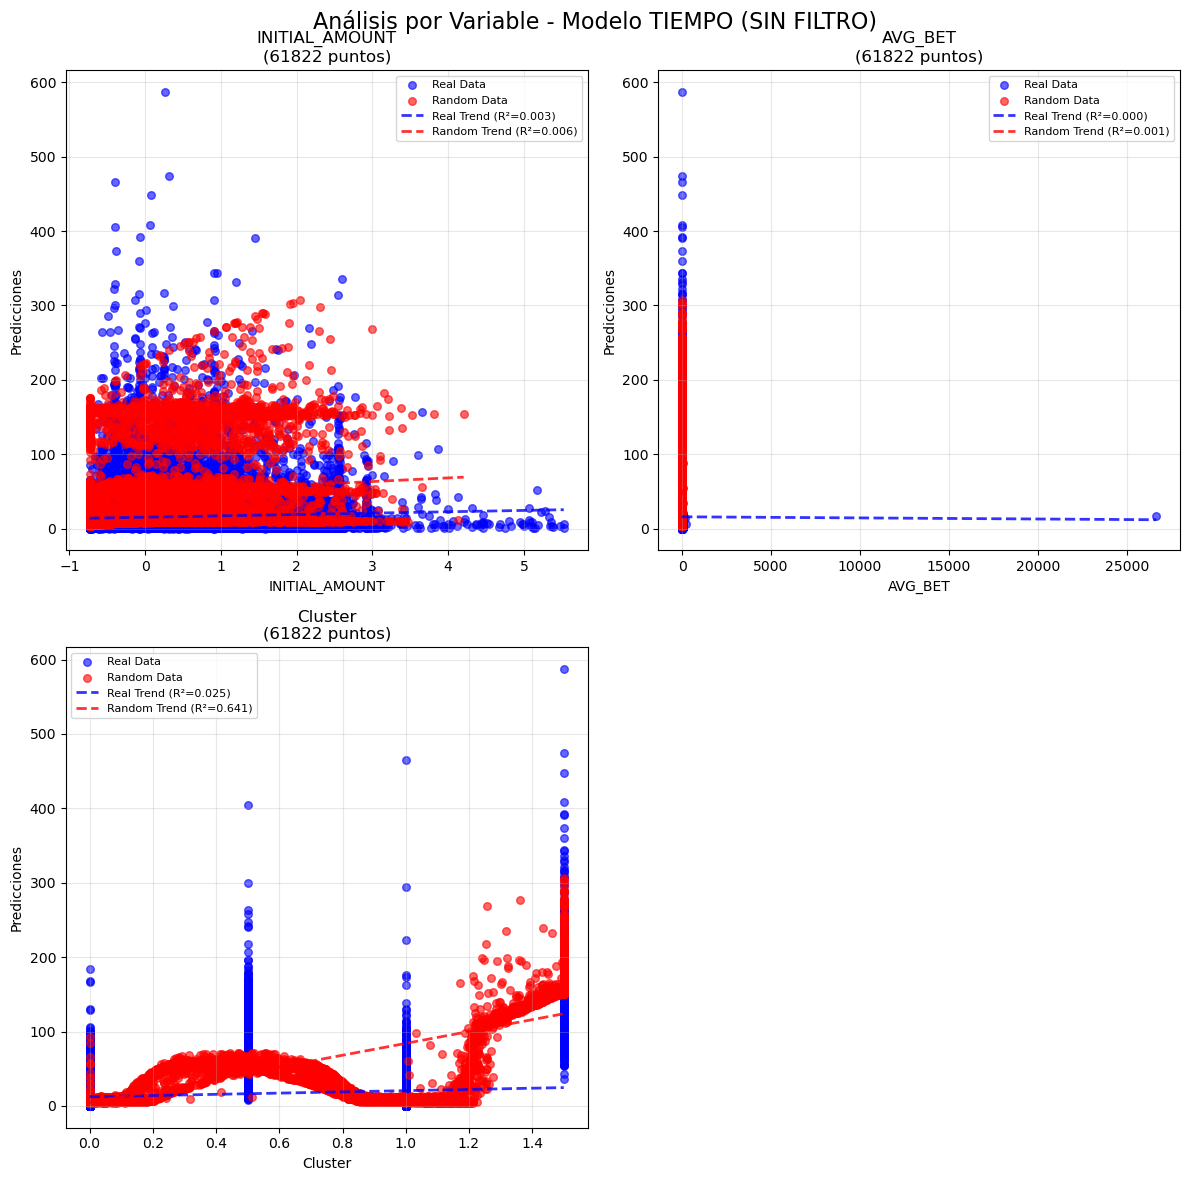

Gráfico guardado: mlp_results/visualizations/tiempo_individual_features_original.png
Gráficos individuales guardados en: mlp_results/visualizations/tiempo_individual/

ENTRENANDO MODELO MLP - BET TOTAL
Epoch 1/100
5183/5183 [==============================] - 19s 3ms/step - loss: 3269918.1887 - mae: 653.5352 - val_loss: 1404696.0000 - val_mae: 477.1684
Epoch 2/100
5183/5183 [==============================] - 12s 2ms/step - loss: 2262498.1539 - mae: 564.0408 - val_loss: 2329963.0000 - val_mae: 473.4132
Epoch 3/100
5183/5183 [==============================] - 9s 2ms/step - loss: 2013522.0274 - mae: 547.5535 - val_loss: 1543384.7500 - val_mae: 450.4864
Epoch 4/100
5183/5183 [==============================] - 10s 2ms/step - loss: 2197422.8292 - mae: 545.8983 - val_loss: 56329232.0000 - val_mae: 787.5705
Epoch 5/100
5183/5183 [==============================] - 10s 2ms/step - loss: 1921876.8092 - mae: 548.1241 - val_loss: 3691008.0000 - val_mae: 459.8635
Epoch 6/100
5183/5183 [===============

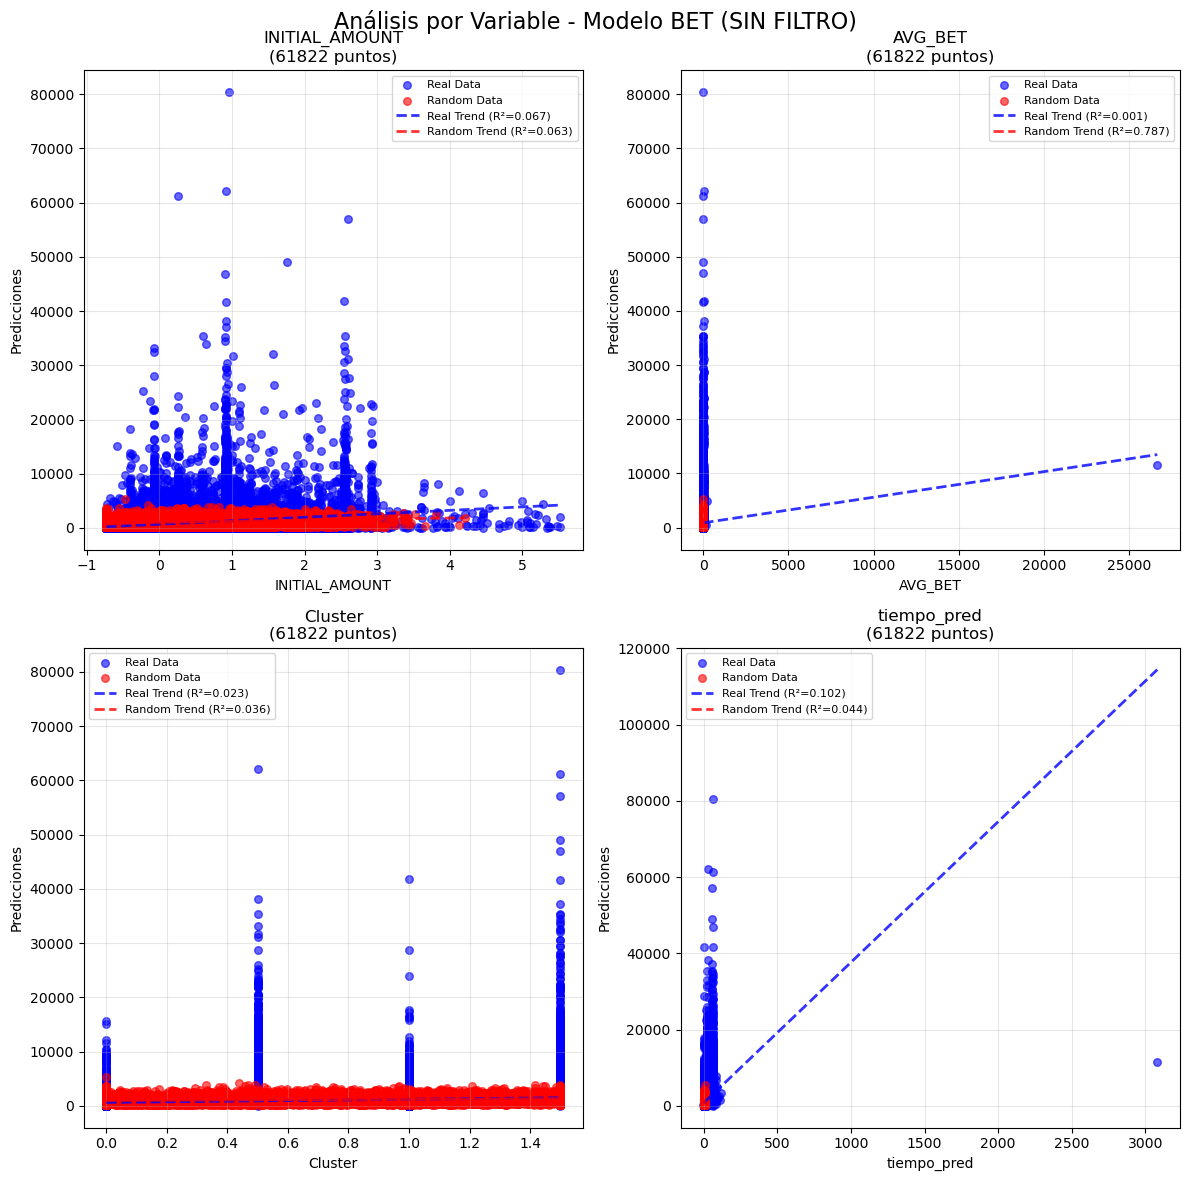

Gráfico guardado: mlp_results/visualizations/bet_individual_features_original.png
Gráficos individuales guardados en: mlp_results/visualizations/bet_individual/

ENTRENANDO MODELO MLP - WIN TOTAL
Epoch 1/100
5183/5183 [==============================] - 24s 4ms/step - loss: 3640679.4912 - mae: 675.5146 - val_loss: 1624179.1250 - val_mae: 540.3595
Epoch 2/100
5183/5183 [==============================] - 14s 3ms/step - loss: 2274754.9024 - mae: 609.9701 - val_loss: 2721517.2500 - val_mae: 572.9620
Epoch 3/100
5183/5183 [==============================] - 15s 3ms/step - loss: 2244869.3823 - mae: 597.6048 - val_loss: 1682372.1250 - val_mae: 531.7061
Epoch 4/100
5183/5183 [==============================] - 15s 3ms/step - loss: 2062053.4603 - mae: 585.6108 - val_loss: 1814922.2500 - val_mae: 516.8264
Epoch 5/100
5183/5183 [==============================] - 16s 3ms/step - loss: 2066087.3790 - mae: 578.9167 - val_loss: 1592045.3750 - val_mae: 526.3356
Epoch 6/100
5183/5183 [=====================

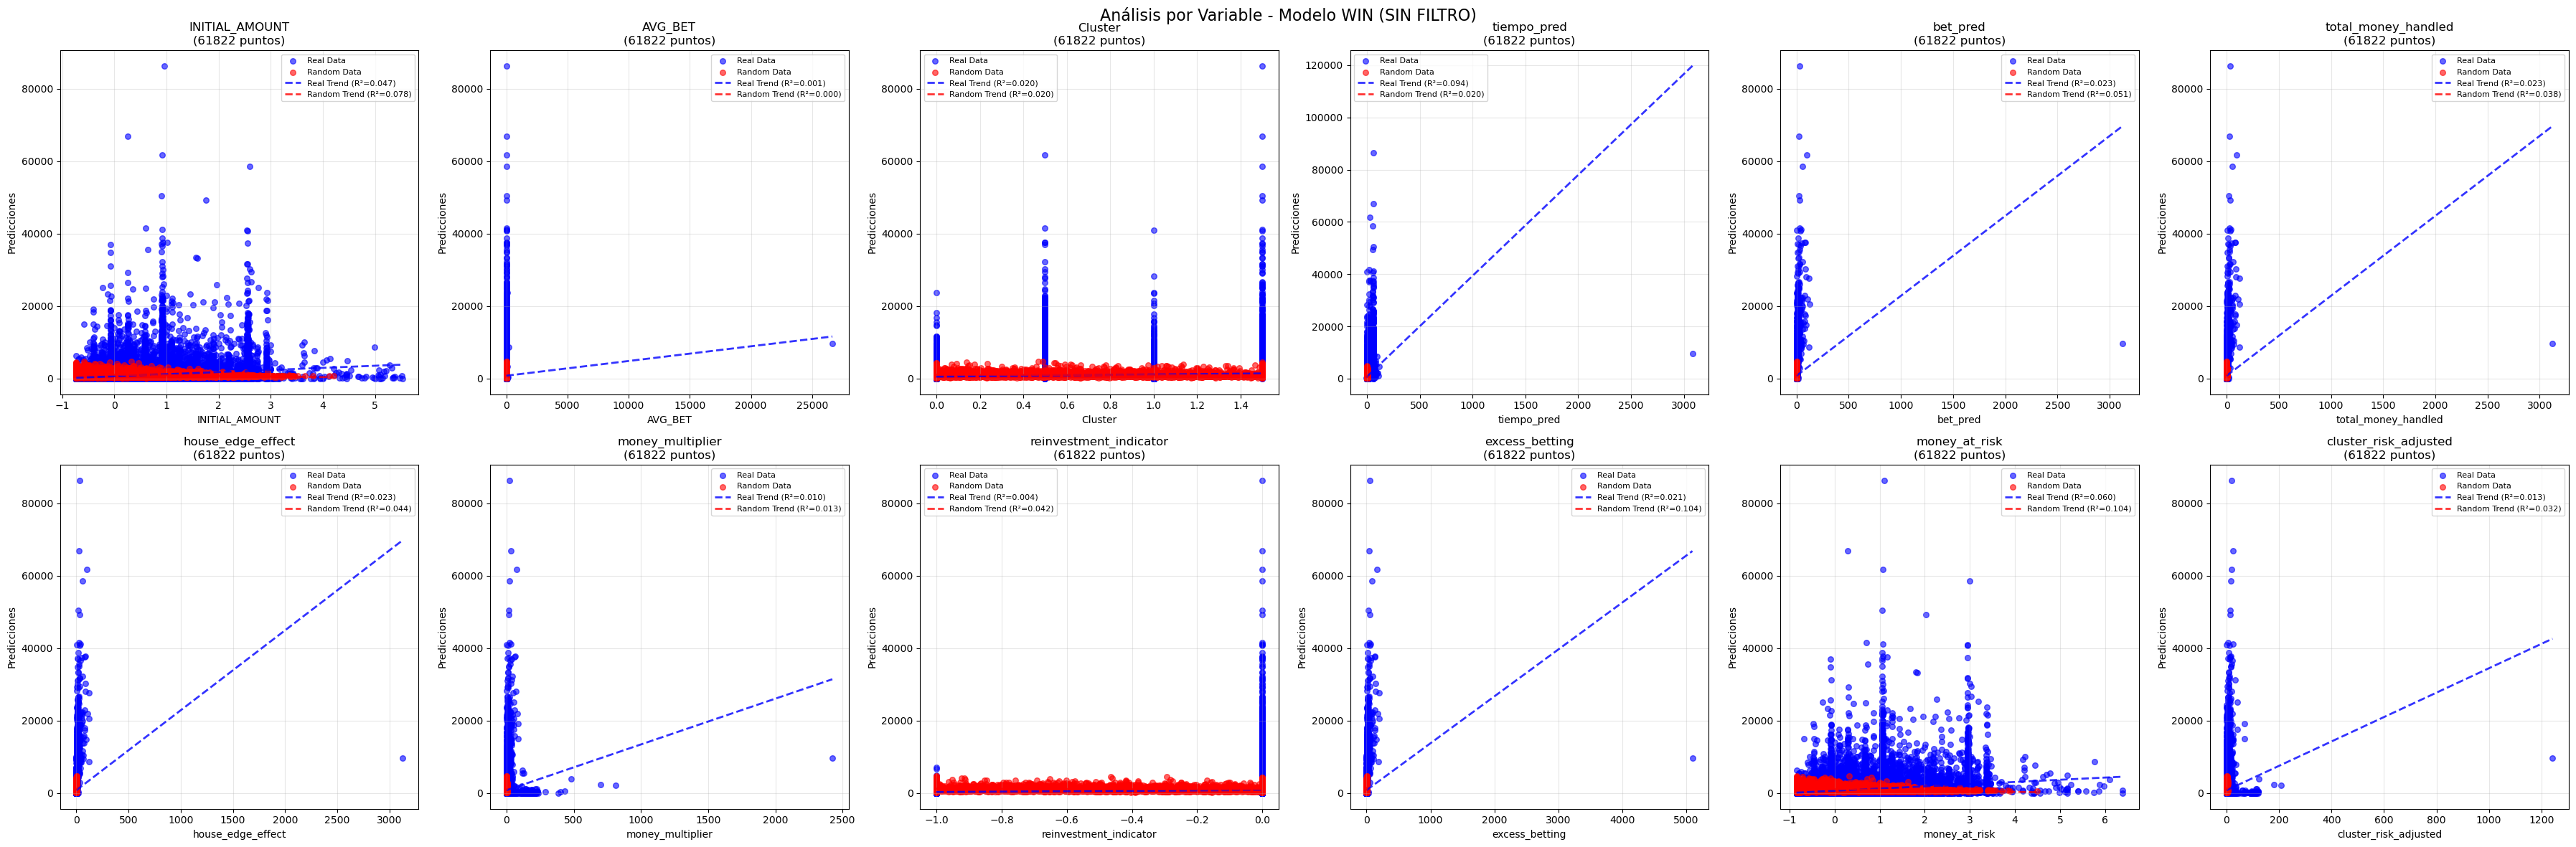

Gráfico guardado: mlp_results/visualizations/win_individual_features_original.png
Gráficos individuales guardados en: mlp_results/visualizations/win_individual/

RESUMEN FINAL - MODELOS MLP
TIEMPO - R²: -1.1408, MAE: 8.9575, RMSE: 36.4947
         Variables: 3 - ['INITIAL_AMOUNT', 'AVG_BET', 'Cluster']
BET    - R²: -12.4863, MAE: 516.6904, RMSE: 6820.3942
         Variables: 4 - ['INITIAL_AMOUNT', 'AVG_BET', 'Cluster', 'tiempo_pred']
WIN    - R²: -478.7452, MAE: 710.0902, RMSE: 44357.4523
         Variables: 12 - ['INITIAL_AMOUNT', 'AVG_BET', 'Cluster', 'tiempo_pred', 'bet_pred', 'total_money_handled', 'house_edge_effect', 'money_multiplier', 'reinvestment_indicator', 'excess_betting', 'money_at_risk', 'cluster_risk_adjusted']

Resumen guardado en: mlp_results/mlp_models_summary.csv
Visualizaciones guardadas en: mlp_results/visualizations/
Configuración guardada en: mlp_results/training_config.json


In [5]:
casino_model = CasinoMLPModel()
resultados = casino_model.train_and_visualize(
    df_data_general, 
    filter_outliers=False,           # Filtrar outliers del dataset
    filter_viz_outliers=False,       # Filtrar outliers en visualizaciones
    n_random_samples=10000,          # Número de muestras aleatorias
    # output_dir='mlp_results'        # Directorio de salida
)

In [6]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import warnings
warnings.filterwarnings('ignore')

class CasinoRNNModel:
    def __init__(self):
        self.scalers = {}
        self.models = {}
        self.feature_names = {}  # Guardar nombres de features por modelo
        
    def filter_outliers(self, df, method='iqr', factor=1.5):
        """
        Filtrar outliers del dataset
        
        Parameters:
        -----------
        df : pandas.DataFrame
            Dataset a filtrar
        method : str
            Método para detectar outliers: 'iqr', 'zscore', 'percentile'
        factor : float
            Factor multiplicativo para el método IQR
        """
        print(f"\n=== FILTRADO DE OUTLIERS (Método: {method.upper()}) ===")
        print(f"Dataset original: {len(df)} registros")
        
        df_filtered = df.copy()
        
        # Columnas numéricas principales para detectar outliers
        numeric_cols = ['BET_TOTAL', 'WIN_TOTAL', 'TIME_ON_DEVICE_MIN', 'INITIAL_AMOUNT']
        
        if method == 'iqr':
            for col in numeric_cols:
                if col in df_filtered.columns:
                    Q1 = df_filtered[col].quantile(0.25)
                    Q3 = df_filtered[col].quantile(0.75)
                    IQR = Q3 - Q1
                    lower_bound = Q1 - factor * IQR
                    upper_bound = Q3 + factor * IQR
                    
                    before_count = len(df_filtered)
                    df_filtered = df_filtered[
                        (df_filtered[col] >= lower_bound) & 
                        (df_filtered[col] <= upper_bound)
                    ]
                    removed = before_count - len(df_filtered)
                    if removed > 0:
                        print(f"{col}: Removidos {removed} outliers (rango: {lower_bound:.1f} - {upper_bound:.1f})")
        
        elif method == 'zscore':
            from scipy import stats
            for col in numeric_cols:
                if col in df_filtered.columns:
                    z_scores = np.abs(stats.zscore(df_filtered[col]))
                    before_count = len(df_filtered)
                    df_filtered = df_filtered[z_scores < 3]  # Mantener z-score < 3
                    removed = before_count - len(df_filtered)
                    if removed > 0:
                        print(f"{col}: Removidos {removed} outliers (z-score >= 3)")
        
        elif method == 'percentile':
            for col in numeric_cols:
                if col in df_filtered.columns:
                    lower_percentile = df_filtered[col].quantile(0.02)
                    upper_percentile = df_filtered[col].quantile(0.98)
                    before_count = len(df_filtered)
                    df_filtered = df_filtered[
                        (df_filtered[col] >= lower_percentile) & 
                        (df_filtered[col] <= upper_percentile)
                    ]
                    removed = before_count - len(df_filtered)
                    if removed > 0:
                        print(f"{col}: Removidos {removed} outliers (percentiles 2-98)")
        
        print(f"Dataset final: {len(df_filtered)} registros")
        print(f"Total removidos: {len(df) - len(df_filtered)} ({(len(df) - len(df_filtered))/len(df)*100:.1f}%)")
        
        return df_filtered
    
    def create_business_features(self, df, tiempo_pred=None, bet_pred=None):
        """
        Crear features que reflejen la lógica real del negocio de casino
        """
        features = df[['INITIAL_AMOUNT', 'AVG_BET', 'Cluster']].copy()
        feature_names = ['INITIAL_AMOUNT', 'AVG_BET', 'Cluster']
        
        if tiempo_pred is not None:
            features['tiempo_pred'] = tiempo_pred
            feature_names.append('tiempo_pred')
            
        if bet_pred is not None:
            features['bet_pred'] = bet_pred
            features['total_money_handled'] = bet_pred
            features['house_edge_effect'] = bet_pred * 0.05
            features['money_multiplier'] = bet_pred / (df['INITIAL_AMOUNT'] + 1)
            features['reinvestment_indicator'] = np.where(bet_pred > df['INITIAL_AMOUNT'], 1, 0)
            features['excess_betting'] = np.maximum(0, bet_pred - df['INITIAL_AMOUNT'])
            features['money_at_risk'] = np.minimum(bet_pred, df['INITIAL_AMOUNT'])
            features['cluster_risk_adjusted'] = df['Cluster'] * features['money_multiplier']
            
            feature_names.extend(['bet_pred', 'total_money_handled', 'house_edge_effect', 
                                'money_multiplier', 'reinvestment_indicator', 
                                'excess_betting', 'money_at_risk', 'cluster_risk_adjusted'])
            
        return features, feature_names
    
    def create_rnn_model(self, input_shape, model_type='tiempo'):
        """
        Crear modelo RNN optimizado
        
        Parameters:
        -----------
        input_shape : int
            Número de features de entrada
        model_type : str
            Tipo de modelo: 'tiempo', 'bet', 'win'
        """
        model = keras.Sequential()
        
        if model_type == 'tiempo':
            # RNN para predicción de tiempo
            model.add(layers.LSTM(128, return_sequences=True, input_shape=(1, input_shape)))
            model.add(layers.BatchNormalization())
            model.add(layers.Dropout(0.3))
            model.add(layers.LSTM(64, return_sequences=True))
            model.add(layers.BatchNormalization())
            model.add(layers.Dropout(0.2))
            model.add(layers.LSTM(32))
            model.add(layers.Dropout(0.1))
            model.add(layers.Dense(16, activation='relu'))
            model.add(layers.Dense(1, activation='linear'))
            
        elif model_type == 'bet':
            # RNN más profunda para BET (más complejo)
            model.add(layers.LSTM(256, return_sequences=True, input_shape=(1, input_shape)))
            model.add(layers.BatchNormalization())
            model.add(layers.Dropout(0.4))
            model.add(layers.LSTM(128, return_sequences=True))
            model.add(layers.BatchNormalization())
            model.add(layers.Dropout(0.3))
            model.add(layers.LSTM(64, return_sequences=True))
            model.add(layers.BatchNormalization())
            model.add(layers.Dropout(0.2))
            model.add(layers.LSTM(32))
            model.add(layers.Dropout(0.1))
            model.add(layers.Dense(16, activation='relu'))
            model.add(layers.Dense(1, activation='linear'))
            
        elif model_type == 'win':
            # RNN más compleja para WIN (más features y complejidad)
            model.add(layers.LSTM(512, return_sequences=True, input_shape=(1, input_shape)))
            model.add(layers.BatchNormalization())
            model.add(layers.Dropout(0.4))
            model.add(layers.LSTM(256, return_sequences=True))
            model.add(layers.BatchNormalization())
            model.add(layers.Dropout(0.3))
            model.add(layers.LSTM(128, return_sequences=True))
            model.add(layers.BatchNormalization())
            model.add(layers.Dropout(0.3))
            model.add(layers.LSTM(64))
            model.add(layers.BatchNormalization())
            model.add(layers.Dropout(0.2))
            model.add(layers.Dense(32, activation='relu'))
            model.add(layers.Dense(16, activation='relu'))
            model.add(layers.Dense(1, activation='linear'))
        
        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=0.001),
            loss='mse',
            metrics=['mae']
        )
        
        return model
    
    def reshape_for_rnn(self, X):
        """
        Reshape data para formato RNN [samples, timesteps, features]
        Para este caso usamos timesteps=1 (cada muestra es independiente)
        """
        return X.reshape((X.shape[0], 1, X.shape[1]))
    
    def generate_random_data(self, X_train, n_samples=1000):
        """
        Generar datos aleatorios basados en las estadísticas de los datos de entrenamiento
        """
        np.random.seed(42)  # Para reproducibilidad
        
        random_data = np.zeros((n_samples, X_train.shape[1]))
        
        for i in range(X_train.shape[1]):
            # Generar datos basados en min, max y distribución de cada feature
            feature_min = X_train[:, i].min()
            feature_max = X_train[:, i].max()
            feature_mean = X_train[:, i].mean()
            feature_std = X_train[:, i].std()
            
            # Usar distribución normal truncada para generar datos más realistas     
            random_data[:, i] = np.random.normal(feature_mean, feature_std, size=n_samples)
            
            # Asegurar que estén en el rango válido
            random_data[:, i] = np.clip(random_data[:, i], feature_min, feature_max)
        
        return random_data
    
    def create_individual_feature_visualizations(self, X_real, y_real, X_random, y_pred_random, 
                                               feature_names, model_name, output_dir='visualizations', 
                                               filter_outliers=True):
        """
        Crear visualizaciones individuales para cada variable de entrada
        """
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        
        # Flatten X si viene en formato RNN (samples, timesteps, features)
        if len(X_real.shape) == 3:
            X_real = X_real.reshape(X_real.shape[0], X_real.shape[2])
        if len(X_random.shape) == 3:
            X_random = X_random.reshape(X_random.shape[0], X_random.shape[2])
        
        n_features = X_real.shape[1]
        print(f"\n=== CREANDO VISUALIZACIONES PARA {n_features} VARIABLES - {model_name.upper()} ===")
        
        # Crear gráfica con subplots
        fig, axes = plt.subplots(2, (n_features + 1) // 2, figsize=(6 * ((n_features + 1) // 2), 12))
        if n_features == 1:
            axes = [axes]
        elif (n_features + 1) // 2 == 1:
            axes = axes.reshape(-1, 1)
        axes = axes.flatten()
        
        for i, feature_name in enumerate(feature_names):
            if i >= len(axes):
                break
                
            # Crear DataFrame para esta variable
            df_viz = pd.DataFrame({
                'Feature_Value': np.concatenate([X_real[:, i], X_random[:, i]]),
                'Predictions': np.concatenate([y_real, y_pred_random]),
                'Data_Type': ['Real'] * len(X_real) + ['Random'] * len(X_random)
            })
            
            # Filtrar outliers si está habilitado
            if filter_outliers:
                # Filtrar por percentiles tanto en X como en Y
                feature_p5 = df_viz['Feature_Value'].quantile(0.05)
                feature_p95 = df_viz['Feature_Value'].quantile(0.95)
                pred_p5 = df_viz['Predictions'].quantile(0.05)
                pred_p95 = df_viz['Predictions'].quantile(0.95)
                
                mask = (
                    (df_viz['Feature_Value'] >= feature_p5) & 
                    (df_viz['Feature_Value'] <= feature_p95) &
                    (df_viz['Predictions'] >= pred_p5) &
                    (df_viz['Predictions'] <= pred_p95)
                )
                
                df_viz_filtered = df_viz[mask].copy()
                removed_points = len(df_viz) - len(df_viz_filtered)
                
                if removed_points > 0:
                    print(f"{feature_name}: Removidos {removed_points} outliers en visualización")
                
                df_viz = df_viz_filtered
            
            # Crear scatter plot en el subplot correspondiente
            ax = axes[i]
            
            # Plot para datos reales
            real_data = df_viz[df_viz['Data_Type'] == 'Real']
            random_data = df_viz[df_viz['Data_Type'] == 'Random']
            
            ax.scatter(real_data['Feature_Value'], real_data['Predictions'], 
                      color='blue', alpha=0.6, s=30, label='Real Data')
            ax.scatter(random_data['Feature_Value'], random_data['Predictions'], 
                      color='red', alpha=0.6, s=30, label='Random Data')
            
            # Líneas de tendencia
            colors = {'Real': 'blue', 'Random': 'red'}
            for data_type, color in colors.items():
                subset = df_viz[df_viz['Data_Type'] == data_type]
                if len(subset) > 1:
                    # Ajustar línea de tendencia
                    lr = LinearRegression()
                    X_trend = subset['Feature_Value'].values.reshape(-1, 1)
                    y_trend = subset['Predictions'].values
                    
                    if np.var(X_trend) > 1e-10:  # Evitar divisiones por cero
                        lr.fit(X_trend, y_trend)
                        
                        # Crear puntos para la línea
                        x_line = np.linspace(subset['Feature_Value'].min(), 
                                           subset['Feature_Value'].max(), 100)
                        y_line = lr.predict(x_line.reshape(-1, 1))
                        
                        # Calcular R² para esta línea
                        try:
                            r2 = lr.score(X_trend, y_trend)
                            ax.plot(x_line, y_line, color=color, linestyle='--', 
                                   alpha=0.8, linewidth=2, 
                                   label=f'{data_type} Trend (R²={r2:.3f})')
                        except:
                            pass
            
            # Personalizar subplot
            ax.set_xlabel(f'{feature_name}')
            ax.set_ylabel('Predicciones')
            ax.set_title(f'{feature_name}\n({len(df_viz)} puntos)')
            ax.legend(fontsize=8)
            ax.grid(True, alpha=0.3)
        
        # Ocultar subplots vacíos
        for i in range(len(feature_names), len(axes)):
            axes[i].set_visible(False)
        
        # Título general y ajustes
        filter_status = "CON FILTRO" if filter_outliers else "SIN FILTRO"
        fig.suptitle(f'Análisis por Variable - Modelo RNN {model_name.upper()} ({filter_status})', 
                     fontsize=16, y=0.98)
        plt.tight_layout()
        plt.subplots_adjust(top=0.93)
        
        # Guardar gráfico
        suffix = "_filtered" if filter_outliers else "_original"
        filename = f"{output_dir}/{model_name}_rnn_individual_features{suffix}.png"
        plt.savefig(filename, dpi=300, bbox_inches='tight')
        plt.show()
        
        print(f"Gráfico guardado: {filename}")
        
        # Crear también gráficos individuales más grandes
        self.create_separate_feature_plots(X_real, y_real, X_random, y_pred_random, 
                                         feature_names, model_name, output_dir, filter_outliers)
        
        return df_viz
    
    def create_separate_feature_plots(self, X_real, y_real, X_random, y_pred_random, 
                                    feature_names, model_name, output_dir, filter_outliers):
        """
        Crear gráficos separados para cada variable (más grandes y detallados)
        """
        individual_dir = f"{output_dir}/{model_name}_rnn_individual"
        if not os.path.exists(individual_dir):
            os.makedirs(individual_dir)
        
        for i, feature_name in enumerate(feature_names):
            plt.figure(figsize=(12, 8))
            
            # Crear DataFrame para esta variable
            df_viz = pd.DataFrame({
                'Feature_Value': np.concatenate([X_real[:, i], X_random[:, i]]),
                'Predictions': np.concatenate([y_real, y_pred_random]),
                'Data_Type': ['Real'] * len(X_real) + ['Random'] * len(X_random)
            })
            
            # Filtrar outliers si está habilitado
            if filter_outliers:
                feature_p5 = df_viz['Feature_Value'].quantile(0.05)
                feature_p95 = df_viz['Feature_Value'].quantile(0.95)
                pred_p5 = df_viz['Predictions'].quantile(0.05)
                pred_p95 = df_viz['Predictions'].quantile(0.95)
                
                mask = (
                    (df_viz['Feature_Value'] >= feature_p5) & 
                    (df_viz['Feature_Value'] <= feature_p95) &
                    (df_viz['Predictions'] >= pred_p5) &
                    (df_viz['Predictions'] <= pred_p95)
                )
                df_viz = df_viz[mask].copy()
            
            # Scatter plot detallado
            sns.scatterplot(data=df_viz, x='Feature_Value', y='Predictions', 
                           hue='Data_Type', alpha=0.7, s=50)
            
            # Líneas de tendencia
            colors = {'Real': 'blue', 'Random': 'red'}
            for data_type, color in colors.items():
                subset = df_viz[df_viz['Data_Type'] == data_type]
                if len(subset) > 1:
                    lr = LinearRegression()
                    X_trend = subset['Feature_Value'].values.reshape(-1, 1)
                    y_trend = subset['Predictions'].values
                    
                    if np.var(X_trend) > 1e-10:
                        lr.fit(X_trend, y_trend)
                        x_line = np.linspace(subset['Feature_Value'].min(), 
                                           subset['Feature_Value'].max(), 100)
                        y_line = lr.predict(x_line.reshape(-1, 1))
                        
                        try:
                            r2 = lr.score(X_trend, y_trend)
                            plt.plot(x_line, y_line, color=color, linestyle='--', 
                                   alpha=0.8, linewidth=2, 
                                   label=f'{data_type} Trend (R²={r2:.3f})')
                        except:
                            pass
            
            # Personalización
            filter_status = "CON FILTRO" if filter_outliers else "SIN FILTRO"
            plt.title(f'Modelo RNN {model_name.upper()} - Variable: {feature_name} ({filter_status})\n'
                     f'Total puntos: {len(df_viz)}', fontsize=14)
            plt.xlabel(f'{feature_name} (Valores Escalados)', fontsize=12)
            plt.ylabel('Predicciones del Modelo', fontsize=12)
            plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
            plt.grid(True, alpha=0.3)
            
            # Estadísticas en el gráfico
            real_corr = np.corrcoef(df_viz[df_viz['Data_Type'] == 'Real']['Feature_Value'], 
                                  df_viz[df_viz['Data_Type'] == 'Real']['Predictions'])[0,1]
            random_corr = np.corrcoef(df_viz[df_viz['Data_Type'] == 'Random']['Feature_Value'], 
                                    df_viz[df_viz['Data_Type'] == 'Random']['Predictions'])[0,1]
            
            stats_text = f'Correlaciones:\nReal: {real_corr:.3f}\nRandom: {random_corr:.3f}'
            plt.text(0.02, 0.98, stats_text, transform=plt.gca().transAxes, 
                    verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
            
            # Guardar
            suffix = "_filtered" if filter_outliers else "_original"
            filename = f"{individual_dir}/{feature_name}{suffix}.png"
            plt.tight_layout()
            plt.savefig(filename, dpi=300, bbox_inches='tight')
            plt.close()  # Cerrar para liberar memoria
        
        print(f"Gráficos individuales guardados en: {individual_dir}/")
    
    def analyze_business_patterns(self, df):
        """Análisis de patrones de negocio"""
        print(f"\n=== ANÁLISIS DE PATRONES DE NEGOCIO ===")
        reinvested = df['BET_TOTAL'] > df['INITIAL_AMOUNT']
        print(f"Sesiones con reinversión: {reinvested.sum()} ({reinvested.sum()/len(df)*100:.1f}%)")
        
        net_winners = df['FINAL_AMOUNT'] > df['INITIAL_AMOUNT']
        net_losers = df['FINAL_AMOUNT'] < df['INITIAL_AMOUNT']
        
        print(f"Ganadores netos: {net_winners.sum()} ({net_winners.sum()/len(df)*100:.1f}%)")
        print(f"Perdedores netos: {net_losers.sum()} ({net_losers.sum()/len(df)*100:.1f}%)")
        
        win_bet_corr = np.corrcoef(df['WIN_TOTAL'], df['BET_TOTAL'])[0,1]
        print(f"Correlación WIN vs BET: {win_bet_corr:.3f}")
        
        print(f"Dataset shape: {df.shape}")
        print(f"Rango TIEMPO: {df['TIME_ON_DEVICE_MIN'].min():.1f} - {df['TIME_ON_DEVICE_MIN'].max():.1f}")
        print(f"Rango BET: {df['BET_TOTAL'].min():.1f} - {df['BET_TOTAL'].max():.1f}")
        print(f"Rango WIN: {df['WIN_TOTAL'].min():.1f} - {df['WIN_TOTAL'].max():.1f}")
    
    def train_and_visualize(self, df, filter_outliers=True, outlier_method='iqr', 
                           filter_viz_outliers=True, n_random_samples=1000, 
                           output_dir='rnn_results'):
        """
        Entrenar modelos RNN y crear visualizaciones individuales por variable
        """
        print("=" * 80)
        print("ENTRENANDO MODELOS RNN CON VISUALIZACIONES POR VARIABLE")
        print("=" * 80)
        
        # Crear directorio de salida
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        
        # Filtrar outliers del dataset si está habilitado
        if filter_outliers:
            df_processed = self.filter_outliers(df, method=outlier_method)
        else:
            df_processed = df.copy()
            print(f"\nSin filtrado de outliers - Dataset: {len(df_processed)} registros")
        
        # Análisis inicial
        self.analyze_business_patterns(df_processed)
        
        # Preparar datos base
        X_base = df_processed[['INITIAL_AMOUNT','AVG_BET','Cluster','Weekday','Weekend','Month']]
        y_tiempo = df_processed['TIME_ON_DEVICE_MIN']
        y_bet = df_processed['BET_TOTAL'] 
        y_win = df_processed['WIN_TOTAL']
        
        # Split estratificado
        X_base_train, X_base_test, y_tiempo_train, y_tiempo_test = train_test_split(
            X_base, y_tiempo, test_size=0.2, random_state=42, 
            stratify=pd.cut(y_tiempo, bins=5, labels=False)
        )
        
        train_idx, test_idx = X_base_train.index, X_base_test.index
        
        # ========== MODELO DE TIEMPO ==========
        print(f"\n{'='*50}")
        print("ENTRENANDO MODELO RNN - TIEMPO")
        print(f"{'='*50}")
        
        X_tiempo_train, feature_names_tiempo = self.create_business_features(X_base_train)
        X_tiempo_test, _ = self.create_business_features(X_base_test)
        
        # Guardar nombres de features
        self.feature_names['tiempo'] = feature_names_tiempo
        
        # Escalar datos
        scaler_tiempo = RobustScaler()
        X_tiempo_train_scaled = scaler_tiempo.fit_transform(X_tiempo_train)
        X_tiempo_test_scaled = scaler_tiempo.transform(X_tiempo_test)
        
        # Reshape para RNN: [samples, timesteps, features]
        X_tiempo_train_rnn = self.reshape_for_rnn(X_tiempo_train_scaled)
        X_tiempo_test_rnn = self.reshape_for_rnn(X_tiempo_test_scaled)
        
        # Entrenar modelo
        model_tiempo = self.create_rnn_model(X_tiempo_train_scaled.shape[1], 'tiempo')
        
        early_stopping = keras.callbacks.EarlyStopping(
            monitor='val_loss', patience=20, restore_best_weights=True
        )
        reduce_lr = keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss', factor=0.5, patience=10, min_lr=0.0001
        )
        
        history_tiempo = model_tiempo.fit(
            X_tiempo_train_rnn, y_tiempo_train.values,
            validation_split=0.2,
            epochs=100,
            batch_size=32,
            callbacks=[early_stopping, reduce_lr],
            verbose=1
        )
        
        # Predicciones en datos reales
        y_tiempo_pred = model_tiempo.predict(X_tiempo_test_rnn, verbose=0).flatten()
        
        # Métricas modelo tiempo
        r2_tiempo = r2_score(y_tiempo_test.values, y_tiempo_pred)
        mae_tiempo = mean_absolute_error(y_tiempo_test.values, y_tiempo_pred)
        rmse_tiempo = np.sqrt(mean_squared_error(y_tiempo_test.values, y_tiempo_pred))
        
        print(f"TIEMPO - R²: {r2_tiempo:.4f}, MAE: {mae_tiempo:.4f}, RMSE: {rmse_tiempo:.4f}")
        
        # Generar datos aleatorios y predecir
        X_random_tiempo = self.generate_random_data(X_tiempo_train_scaled, n_random_samples)
        X_random_tiempo_rnn = self.reshape_for_rnn(X_random_tiempo)
        y_random_tiempo_pred = model_tiempo.predict(X_random_tiempo_rnn, verbose=0).flatten()
        
        # Crear visualizaciones por variable para tiempo
        viz_tiempo = self.create_individual_feature_visualizations(
            X_tiempo_test_rnn, y_tiempo_test.values, 
            X_random_tiempo_rnn, y_random_tiempo_pred, 
            feature_names_tiempo, 'tiempo', f"{output_dir}/visualizations", filter_viz_outliers
        )
        
        self.models['tiempo'] = model_tiempo
        self.scalers['tiempo'] = scaler_tiempo
        
        # Predicciones de tiempo para usar en modelos siguientes
        tiempo_pred_train = model_tiempo.predict(X_tiempo_train_rnn, verbose=0).flatten()
        tiempo_pred_test = y_tiempo_pred
        
        # ========== MODELO DE BET ==========
        print(f"\n{'='*50}")
        print("ENTRENANDO MODELO RNN - BET TOTAL")
        print(f"{'='*50}")
        
        X_bet_train, feature_names_bet = self.create_business_features(X_base_train, tiempo_pred_train)
        X_bet_test, _ = self.create_business_features(X_base_test, tiempo_pred_test)
        
        # Guardar nombres de features
        self.feature_names['bet'] = feature_names_bet
        
        # Escalar datos
        scaler_bet = RobustScaler()
        X_bet_train_scaled = scaler_bet.fit_transform(X_bet_train)
        X_bet_test_scaled = scaler_bet.transform(X_bet_test)
        
        # Reshape para RNN
        X_bet_train_rnn = self.reshape_for_rnn(X_bet_train_scaled)
        X_bet_test_rnn = self.reshape_for_rnn(X_bet_test_scaled)
        
        # Entrenar modelo
        model_bet = self.create_rnn_model(X_bet_train_scaled.shape[1], 'bet')
        
        history_bet = model_bet.fit(
            X_bet_train_rnn, y_bet.loc[train_idx].values,
            validation_split=0.2,
            epochs=100,
            batch_size=32,
            callbacks=[early_stopping, reduce_lr],
            verbose=1
        )
        
        # Predicciones en datos reales
        y_bet_pred = model_bet.predict(X_bet_test_rnn, verbose=0).flatten()
        
        # Métricas modelo bet
        r2_bet = r2_score(y_bet.loc[test_idx].values, y_bet_pred)
        mae_bet = mean_absolute_error(y_bet.loc[test_idx].values, y_bet_pred)
        rmse_bet = np.sqrt(mean_squared_error(y_bet.loc[test_idx].values, y_bet_pred))
        
        print(f"BET - R²: {r2_bet:.4f}, MAE: {mae_bet:.4f}, RMSE: {rmse_bet:.4f}")
        
        # Generar datos aleatorios y predecir
        X_random_bet = self.generate_random_data(X_bet_train_scaled, n_random_samples)
        X_random_bet_rnn = self.reshape_for_rnn(X_random_bet)
        y_random_bet_pred = model_bet.predict(X_random_bet_rnn, verbose=0).flatten()
        
        # Crear visualizaciones por variable para bet
        viz_bet = self.create_individual_feature_visualizations(
            X_bet_test_rnn, y_bet.loc[test_idx].values,
            X_random_bet_rnn, y_random_bet_pred,
            feature_names_bet, 'bet', f"{output_dir}/visualizations", filter_viz_outliers
        )
        
        self.models['bet'] = model_bet
        self.scalers['bet'] = scaler_bet
        
        # Predicciones de bet para modelo win
        bet_pred_train = model_bet.predict(X_bet_train_rnn, verbose=0).flatten()
        bet_pred_test = y_bet_pred
        
        # ========== MODELO DE WIN ==========
        print(f"\n{'='*50}")
        print("ENTRENANDO MODELO RNN - WIN TOTAL")
        print(f"{'='*50}")
        
        X_win_train, feature_names_win = self.create_business_features(X_base_train, tiempo_pred_train, bet_pred_train)
        X_win_test, _ = self.create_business_features(X_base_test, tiempo_pred_test, bet_pred_test)
        
        # Guardar nombres de features
        self.feature_names['win'] = feature_names_win
        
        # Escalar datos
        scaler_win = RobustScaler()
        X_win_train_scaled = scaler_win.fit_transform(X_win_train)
        X_win_test_scaled = scaler_win.transform(X_win_test)
        
        # Reshape para RNN
        X_win_train_rnn = self.reshape_for_rnn(X_win_train_scaled)
        X_win_test_rnn = self.reshape_for_rnn(X_win_test_scaled)
        
        # Entrenar modelo
        model_win = self.create_rnn_model(X_win_train_scaled.shape[1], 'win')
        
        history_win = model_win.fit(
            X_win_train_rnn, y_win.loc[train_idx].values,
            validation_split=0.2,
            epochs=100,
            batch_size=32,
            callbacks=[early_stopping, reduce_lr],
            verbose=1
        )
        
        # Predicciones en datos reales
        y_win_pred = model_win.predict(X_win_test_rnn, verbose=0).flatten()
        
        # Métricas modelo win
        r2_win = r2_score(y_win.loc[test_idx].values, y_win_pred)
        mae_win = mean_absolute_error(y_win.loc[test_idx].values, y_win_pred)
        rmse_win = np.sqrt(mean_squared_error(y_win.loc[test_idx].values, y_win_pred))
        
        print(f"WIN - R²: {r2_win:.4f}, MAE: {mae_win:.4f}, RMSE: {rmse_win:.4f}")
        
        # Generar datos aleatorios y predecir
        X_random_win = self.generate_random_data(X_win_train_scaled, n_random_samples)
        X_random_win_rnn = self.reshape_for_rnn(X_random_win)
        y_random_win_pred = model_win.predict(X_random_win_rnn, verbose=0).flatten()
        
        # Crear visualizaciones por variable para win
        viz_win = self.create_individual_feature_visualizations(
            X_win_test_rnn, y_win.loc[test_idx].values,
            X_random_win_rnn, y_random_win_pred,
            feature_names_win, 'win', f"{output_dir}/visualizations", filter_viz_outliers
        )
        
        self.models['win'] = model_win
        self.scalers['win'] = scaler_win
        
        # ========== RESUMEN FINAL ==========
        print(f"\n{'='*80}")
        print("RESUMEN FINAL - MODELOS RNN")
        print(f"{'='*80}")
        print(f"TIEMPO - R²: {r2_tiempo:.4f}, MAE: {mae_tiempo:.4f}, RMSE: {rmse_tiempo:.4f}")
        print(f"         Variables: {len(feature_names_tiempo)} - {feature_names_tiempo}")
        print(f"BET    - R²: {r2_bet:.4f}, MAE: {mae_bet:.4f}, RMSE: {rmse_bet:.4f}")
        print(f"         Variables: {len(feature_names_bet)} - {feature_names_bet}")
        print(f"WIN    - R²: {r2_win:.4f}, MAE: {mae_win:.4f}, RMSE: {rmse_win:.4f}")
        print(f"         Variables: {len(feature_names_win)} - {feature_names_win}")
        
        # Información de filtrado aplicado
        config_info = {
            'model_type': 'RNN (LSTM)',
            'outlier_filtering': filter_outliers,
            'outlier_method': outlier_method if filter_outliers else None,
            'viz_filtering': filter_viz_outliers,
            'original_samples': len(df),
            'processed_samples': len(df_processed),
            'feature_names': self.feature_names
        }
        
        # Crear CSV con resumen detallado
        results_summary = pd.DataFrame([
            {
                'Model': 'TIEMPO', 
                'R2': r2_tiempo, 
                'MAE': mae_tiempo, 
                'RMSE': rmse_tiempo,
                'N_Features': len(feature_names_tiempo),
                'Features': ', '.join(feature_names_tiempo)
            },
            {
                'Model': 'BET', 
                'R2': r2_bet, 
                'MAE': mae_bet, 
                'RMSE': rmse_bet,
                'N_Features': len(feature_names_bet),
                'Features': ', '.join(feature_names_bet)
            },
            {
                'Model': 'WIN', 
                'R2': r2_win, 
                'MAE': mae_win, 
                'RMSE': rmse_win,
                'N_Features': len(feature_names_win),
                'Features': ', '.join(feature_names_win)
            }
        ])
        
        summary_file = f"{output_dir}/rnn_models_summary.csv"
        results_summary.to_csv(summary_file, index=False)
        print(f"\nResumen guardado en: {summary_file}")
        print(f"Visualizaciones guardadas en: {output_dir}/visualizations/")
        
        # Crear archivo de configuración
        import json
        config_file = f"{output_dir}/training_config.json"
        with open(config_file, 'w') as f:
            # Convertir feature_names a formato serializable
            config_serializable = config_info.copy()
            json.dump(config_serializable, f, indent=2)
        print(f"Configuración guardada en: {config_file}")
        
        return {
            'models': self.models,
            'scalers': self.scalers,
            'feature_names': self.feature_names,
            'results': results_summary,
            'config': config_info,
            'visualizations': {
                'tiempo': viz_tiempo,
                'bet': viz_bet,
                'win': viz_win
            }
        }
    
    def predict(self, initial_amount, avg_bet, cluster, weekday=0, weekend=0, month=1):
        """
        Hacer predicciones con los modelos RNN entrenados
        
        Parameters:
        -----------
        initial_amount : float
            Monto inicial
        avg_bet : float
            Apuesta promedio
        cluster : int
            Cluster del jugador
        weekday : int
            Día de la semana (0-6)
        weekend : int
            Es fin de semana (0 o 1)
        month : int
            Mes (1-12)
            
        Returns:
        --------
        dict : Diccionario con predicciones de tiempo, bet y win
        """
        # Crear DataFrame con los datos de entrada
        input_data = pd.DataFrame({
            'INITIAL_AMOUNT': [initial_amount],
            'AVG_BET': [avg_bet],
            'Cluster': [cluster],
            'Weekday': [weekday],
            'Weekend': [weekend],
            'Month': [month]
        })
        
        # Predecir TIEMPO
        X_tiempo, _ = self.create_business_features(input_data)
        X_tiempo_scaled = self.scalers['tiempo'].transform(X_tiempo)
        X_tiempo_rnn = self.reshape_for_rnn(X_tiempo_scaled)
        tiempo_pred = self.models['tiempo'].predict(X_tiempo_rnn, verbose=0)[0][0]
        
        # Predecir BET
        X_bet, _ = self.create_business_features(input_data, tiempo_pred)
        X_bet_scaled = self.scalers['bet'].transform(X_bet)
        X_bet_rnn = self.reshape_for_rnn(X_bet_scaled)
        bet_pred = self.models['bet'].predict(X_bet_rnn, verbose=0)[0][0]
        
        # Predecir WIN
        X_win, _ = self.create_business_features(input_data, tiempo_pred, bet_pred)
        X_win_scaled = self.scalers['win'].transform(X_win)
        X_win_rnn = self.reshape_for_rnn(X_win_scaled)
        win_pred = self.models['win'].predict(X_win_rnn, verbose=0)[0][0]
        
        return {
            'tiempo_predicho': tiempo_pred,
            'bet_predicho': bet_pred,
            'win_predicho': win_pred,
            'ganancia_neta': win_pred - bet_pred,
            'final_amount_estimado': initial_amount + (win_pred - bet_pred)
        }


ENTRENANDO MODELOS RNN CON VISUALIZACIONES POR VARIABLE

Sin filtrado de outliers - Dataset: 259110 registros

=== ANÁLISIS DE PATRONES DE NEGOCIO ===
Sesiones con reinversión: 198406 (76.6%)
Ganadores netos: 44250 (17.1%)
Perdedores netos: 214330 (82.7%)
Correlación WIN vs BET: 0.971
Dataset shape: (259110, 31)
Rango TIEMPO: 0.1 - 587.1
Rango BET: 0.0 - 151346.0
Rango WIN: 0.0 - 150630.5

ENTRENANDO MODELO RNN - TIEMPO
Epoch 1/100
5183/5183 [==============================] - 45s 7ms/step - loss: 451.2863 - mae: 11.2922 - val_loss: 222.6215 - val_mae: 8.6556
Epoch 2/100
5183/5183 [==============================] - 24s 5ms/step - loss: 231.8083 - mae: 9.0038 - val_loss: 208.3990 - val_mae: 8.5888
Epoch 3/100
5183/5183 [==============================] - 27s 5ms/step - loss: 234.3309 - mae: 8.9896 - val_loss: 206.9498 - val_mae: 8.5655
Epoch 4/100
5183/5183 [==============================] - 24s 5ms/step - loss: 222.7067 - mae: 8.8706 - val_loss: 207.2434 - val_mae: 8.6905
Epoch 5/100
518

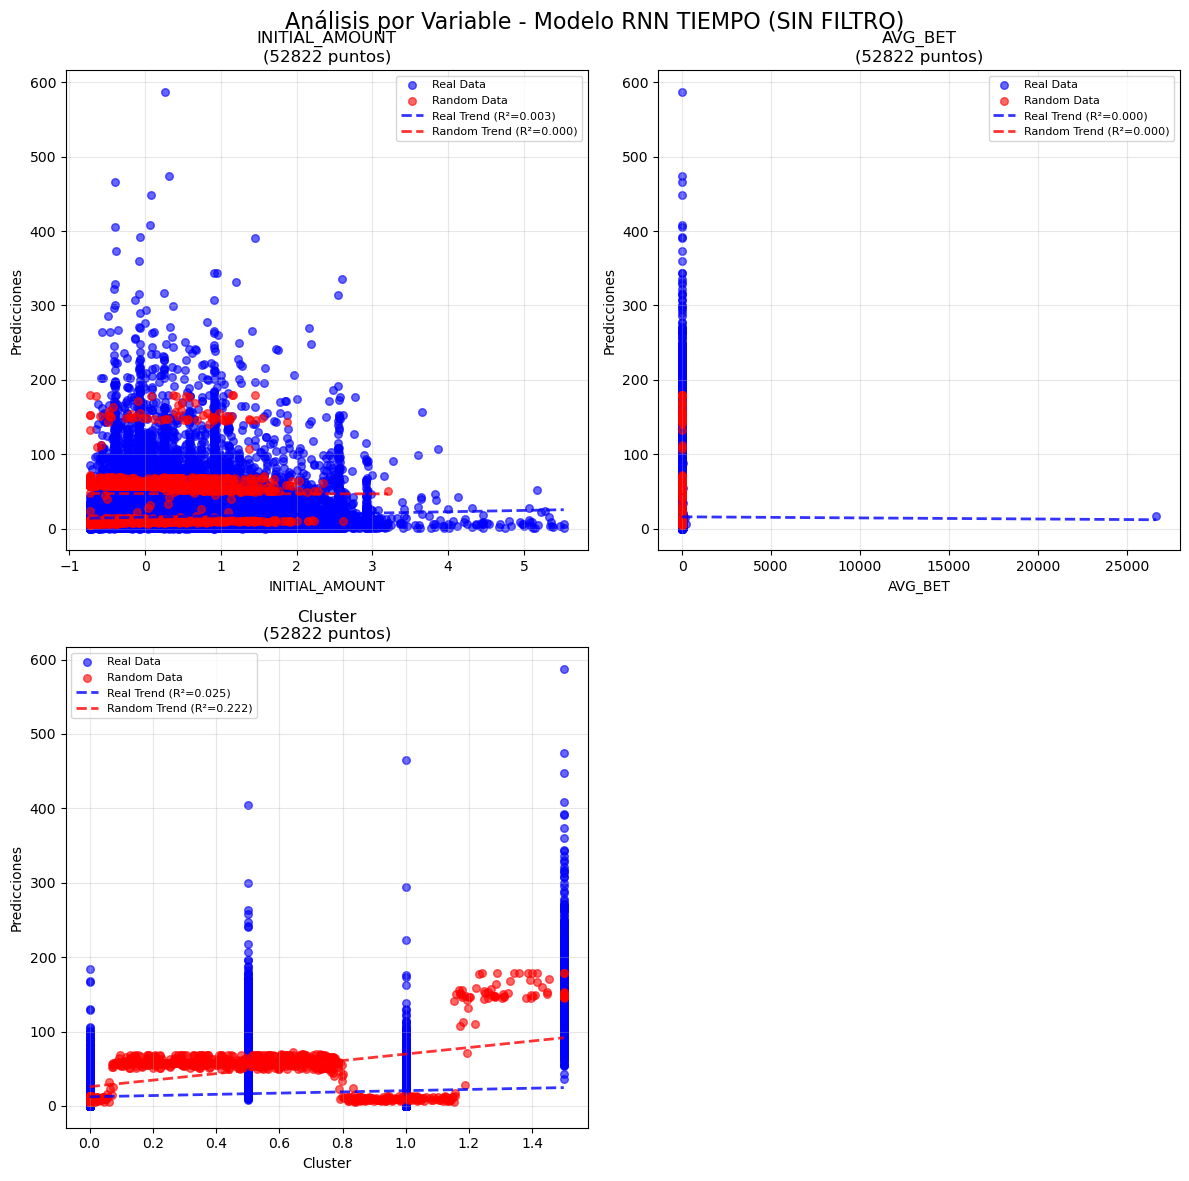

Gráfico guardado: rnn_results/visualizations/tiempo_rnn_individual_features_original.png
Gráficos individuales guardados en: rnn_results/visualizations/tiempo_rnn_individual/

ENTRENANDO MODELO RNN - BET TOTAL
Epoch 1/100
5183/5183 [==============================] - 45s 8ms/step - loss: 4196232.9395 - mae: 712.1926 - val_loss: 2772469.2500 - val_mae: 519.7762
Epoch 2/100
5183/5183 [==============================] - 35s 7ms/step - loss: 2714517.6259 - mae: 527.8181 - val_loss: 2193481.2500 - val_mae: 484.9400
Epoch 3/100
5183/5183 [==============================] - 37s 7ms/step - loss: 2079247.8481 - mae: 503.7469 - val_loss: 1941434.8750 - val_mae: 472.5065
Epoch 4/100
5183/5183 [==============================] - 37s 7ms/step - loss: 2212154.0196 - mae: 500.1984 - val_loss: 1741422.6250 - val_mae: 466.3047
Epoch 5/100
5183/5183 [==============================] - 38s 7ms/step - loss: 2444381.5582 - mae: 498.7014 - val_loss: 1634022.6250 - val_mae: 462.3932
Epoch 6/100
5183/5183 [=======

KeyboardInterrupt: 

In [7]:
casino_rnn = CasinoRNNModel()

# Entrenar modelos con visualizaciones
results = casino_rnn.train_and_visualize(
    df_data_general, 
    filter_outliers=False,
    outlier_method='iqr',
    filter_viz_outliers=False,
    n_random_samples=1000,
    output_dir='rnn_results'
)

In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import warnings
warnings.filterwarnings('ignore')

class CasinoLSTMModel:
    def __init__(self):
        self.scalers = {}
        self.models = {}
        self.feature_names = {}  # Guardar nombres de features por modelo
        
    def filter_outliers(self, df, method='iqr', factor=1.5):
        """
        Filtrar outliers del dataset
        
        Parameters:
        -----------
        df : pandas.DataFrame
            Dataset a filtrar
        method : str
            Método para detectar outliers: 'iqr', 'zscore', 'percentile'
        factor : float
            Factor multiplicativo para el método IQR
        """
        print(f"\n=== FILTRADO DE OUTLIERS (Método: {method.upper()}) ===")
        print(f"Dataset original: {len(df)} registros")
        
        df_filtered = df.copy()
        
        # Columnas numéricas principales para detectar outliers
        numeric_cols = ['BET_TOTAL', 'WIN_TOTAL', 'TIME_ON_DEVICE_MIN', 'INITIAL_AMOUNT']
        
        if method == 'iqr':
            for col in numeric_cols:
                if col in df_filtered.columns:
                    Q1 = df_filtered[col].quantile(0.25)
                    Q3 = df_filtered[col].quantile(0.75)
                    IQR = Q3 - Q1
                    lower_bound = Q1 - factor * IQR
                    upper_bound = Q3 + factor * IQR
                    
                    before_count = len(df_filtered)
                    df_filtered = df_filtered[
                        (df_filtered[col] >= lower_bound) & 
                        (df_filtered[col] <= upper_bound)
                    ]
                    removed = before_count - len(df_filtered)
                    if removed > 0:
                        print(f"{col}: Removidos {removed} outliers (rango: {lower_bound:.1f} - {upper_bound:.1f})")
        
        elif method == 'zscore':
            from scipy import stats
            for col in numeric_cols:
                if col in df_filtered.columns:
                    z_scores = np.abs(stats.zscore(df_filtered[col]))
                    before_count = len(df_filtered)
                    df_filtered = df_filtered[z_scores < 3]  # Mantener z-score < 3
                    removed = before_count - len(df_filtered)
                    if removed > 0:
                        print(f"{col}: Removidos {removed} outliers (z-score >= 3)")
        
        elif method == 'percentile':
            for col in numeric_cols:
                if col in df_filtered.columns:
                    lower_percentile = df_filtered[col].quantile(0.02)
                    upper_percentile = df_filtered[col].quantile(0.98)
                    before_count = len(df_filtered)
                    df_filtered = df_filtered[
                        (df_filtered[col] >= lower_percentile) & 
                        (df_filtered[col] <= upper_percentile)
                    ]
                    removed = before_count - len(df_filtered)
                    if removed > 0:
                        print(f"{col}: Removidos {removed} outliers (percentiles 2-98)")
        
        print(f"Dataset final: {len(df_filtered)} registros")
        print(f"Total removidos: {len(df) - len(df_filtered)} ({(len(df) - len(df_filtered))/len(df)*100:.1f}%)")
        
        return df_filtered
    
    def create_business_features(self, df, tiempo_pred=None, bet_pred=None):
        """
        Crear features que reflejen la lógica real del negocio de casino
        """
        features = df[['INITIAL_AMOUNT', 'AVG_BET', 'Cluster']].copy()
        feature_names = ['INITIAL_AMOUNT', 'AVG_BET', 'Cluster']
        
        if tiempo_pred is not None:
            features['tiempo_pred'] = tiempo_pred
            feature_names.append('tiempo_pred')
            
        if bet_pred is not None:
            features['bet_pred'] = bet_pred
            features['total_money_handled'] = bet_pred
            features['house_edge_effect'] = bet_pred * 0.05
            features['money_multiplier'] = bet_pred / (df['INITIAL_AMOUNT'] + 1)
            features['reinvestment_indicator'] = np.where(bet_pred > df['INITIAL_AMOUNT'], 1, 0)
            features['excess_betting'] = np.maximum(0, bet_pred - df['INITIAL_AMOUNT'])
            features['money_at_risk'] = np.minimum(bet_pred, df['INITIAL_AMOUNT'])
            features['cluster_risk_adjusted'] = df['Cluster'] * features['money_multiplier']
            
            feature_names.extend(['bet_pred', 'total_money_handled', 'house_edge_effect', 
                                'money_multiplier', 'reinvestment_indicator', 
                                'excess_betting', 'money_at_risk', 'cluster_risk_adjusted'])
            
        return features, feature_names
    
    def create_lstm_model(self, input_shape, model_type='tiempo'):
        """
        Crear modelo LSTM optimizado
        
        Parameters:
        -----------
        input_shape : int
            Número de features de entrada
        model_type : str
            Tipo de modelo: 'tiempo', 'bet', 'win'
        """
        model = keras.Sequential(name=f'LSTM_{model_type}')
        
        if model_type == 'tiempo':
            # LSTM para predicción de tiempo
            model.add(layers.LSTM(128, return_sequences=True, input_shape=(1, input_shape), name='lstm_1'))
            model.add(layers.BatchNormalization(name='bn_1'))
            model.add(layers.Dropout(0.3, name='dropout_1'))
            model.add(layers.LSTM(64, return_sequences=True, name='lstm_2'))
            model.add(layers.BatchNormalization(name='bn_2'))
            model.add(layers.Dropout(0.2, name='dropout_2'))
            model.add(layers.LSTM(32, name='lstm_3'))
            model.add(layers.Dropout(0.1, name='dropout_3'))
            model.add(layers.Dense(16, activation='relu', name='dense_1'))
            model.add(layers.Dense(1, activation='linear', name='output'))
            
        elif model_type == 'bet':
            # LSTM más profunda para BET (más complejo)
            model.add(layers.LSTM(256, return_sequences=True, input_shape=(1, input_shape), name='lstm_1'))
            model.add(layers.BatchNormalization(name='bn_1'))
            model.add(layers.Dropout(0.4, name='dropout_1'))
            model.add(layers.LSTM(128, return_sequences=True, name='lstm_2'))
            model.add(layers.BatchNormalization(name='bn_2'))
            model.add(layers.Dropout(0.3, name='dropout_2'))
            model.add(layers.LSTM(64, return_sequences=True, name='lstm_3'))
            model.add(layers.BatchNormalization(name='bn_3'))
            model.add(layers.Dropout(0.2, name='dropout_3'))
            model.add(layers.LSTM(32, name='lstm_4'))
            model.add(layers.Dropout(0.1, name='dropout_4'))
            model.add(layers.Dense(16, activation='relu', name='dense_1'))
            model.add(layers.Dense(1, activation='linear', name='output'))
            
        elif model_type == 'win':
            # LSTM más compleja para WIN (más features y complejidad)
            model.add(layers.LSTM(512, return_sequences=True, input_shape=(1, input_shape), name='lstm_1'))
            model.add(layers.BatchNormalization(name='bn_1'))
            model.add(layers.Dropout(0.4, name='dropout_1'))
            model.add(layers.LSTM(256, return_sequences=True, name='lstm_2'))
            model.add(layers.BatchNormalization(name='bn_2'))
            model.add(layers.Dropout(0.3, name='dropout_2'))
            model.add(layers.LSTM(128, return_sequences=True, name='lstm_3'))
            model.add(layers.BatchNormalization(name='bn_3'))
            model.add(layers.Dropout(0.3, name='dropout_3'))
            model.add(layers.LSTM(64, name='lstm_4'))
            model.add(layers.BatchNormalization(name='bn_4'))
            model.add(layers.Dropout(0.2, name='dropout_4'))
            model.add(layers.Dense(32, activation='relu', name='dense_1'))
            model.add(layers.Dense(16, activation='relu', name='dense_2'))
            model.add(layers.Dense(1, activation='linear', name='output'))
        
        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=0.001),
            loss='mse',
            metrics=['mae']
        )
        
        return model
    
    def reshape_for_lstm(self, X):
        """
        Reshape data para formato LSTM [samples, timesteps, features]
        Para este caso usamos timesteps=1 (cada muestra es independiente)
        """
        return X.reshape((X.shape[0], 1, X.shape[1]))
    
    def generate_random_data(self, X_train, n_samples=1000):
        """
        Generar datos aleatorios basados en las estadísticas de los datos de entrenamiento
        """
        np.random.seed(42)  # Para reproducibilidad
        
        random_data = np.zeros((n_samples, X_train.shape[1]))
        
        for i in range(X_train.shape[1]):
            # Generar datos basados en min, max y distribución de cada feature
            feature_min = X_train[:, i].min()
            feature_max = X_train[:, i].max()
            feature_mean = X_train[:, i].mean()
            feature_std = X_train[:, i].std()
            
            # Usar distribución normal truncada para generar datos más realistas     
            random_data[:, i] = np.random.normal(feature_mean, feature_std, size=n_samples)
            
            # Asegurar que estén en el rango válido
            random_data[:, i] = np.clip(random_data[:, i], feature_min, feature_max)
        
        return random_data
    
    def create_individual_feature_visualizations(self, X_real, y_real, X_random, y_pred_random, 
                                               feature_names, model_name, output_dir='visualizations', 
                                               filter_outliers=True):
        """
        Crear visualizaciones individuales para cada variable de entrada
        """
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        
        # Flatten X si viene en formato LSTM (samples, timesteps, features)
        if len(X_real.shape) == 3:
            X_real = X_real.reshape(X_real.shape[0], X_real.shape[2])
        if len(X_random.shape) == 3:
            X_random = X_random.reshape(X_random.shape[0], X_random.shape[2])
        
        n_features = X_real.shape[1]
        print(f"\n=== CREANDO VISUALIZACIONES PARA {n_features} VARIABLES - {model_name.upper()} ===")
        
        # Crear gráfica con subplots
        fig, axes = plt.subplots(2, (n_features + 1) // 2, figsize=(6 * ((n_features + 1) // 2), 12))
        if n_features == 1:
            axes = [axes]
        elif (n_features + 1) // 2 == 1:
            axes = axes.reshape(-1, 1)
        axes = axes.flatten()
        
        for i, feature_name in enumerate(feature_names):
            if i >= len(axes):
                break
                
            # Crear DataFrame para esta variable
            df_viz = pd.DataFrame({
                'Feature_Value': np.concatenate([X_real[:, i], X_random[:, i]]),
                'Predictions': np.concatenate([y_real, y_pred_random]),
                'Data_Type': ['Real'] * len(X_real) + ['Random'] * len(X_random)
            })
            
            # Filtrar outliers si está habilitado
            if filter_outliers:
                # Filtrar por percentiles tanto en X como en Y
                feature_p5 = df_viz['Feature_Value'].quantile(0.05)
                feature_p95 = df_viz['Feature_Value'].quantile(0.95)
                pred_p5 = df_viz['Predictions'].quantile(0.05)
                pred_p95 = df_viz['Predictions'].quantile(0.95)
                
                mask = (
                    (df_viz['Feature_Value'] >= feature_p5) & 
                    (df_viz['Feature_Value'] <= feature_p95) &
                    (df_viz['Predictions'] >= pred_p5) &
                    (df_viz['Predictions'] <= pred_p95)
                )
                
                df_viz_filtered = df_viz[mask].copy()
                removed_points = len(df_viz) - len(df_viz_filtered)
                
                if removed_points > 0:
                    print(f"{feature_name}: Removidos {removed_points} outliers en visualización")
                
                df_viz = df_viz_filtered
            
            # Crear scatter plot en el subplot correspondiente
            ax = axes[i]
            
            # Plot para datos reales
            real_data = df_viz[df_viz['Data_Type'] == 'Real']
            random_data = df_viz[df_viz['Data_Type'] == 'Random']
            
            ax.scatter(real_data['Feature_Value'], real_data['Predictions'], 
                      color='blue', alpha=0.6, s=30, label='Real Data')
            ax.scatter(random_data['Feature_Value'], random_data['Predictions'], 
                      color='red', alpha=0.6, s=30, label='Random Data')
            
            # Líneas de tendencia
            colors = {'Real': 'blue', 'Random': 'red'}
            for data_type, color in colors.items():
                subset = df_viz[df_viz['Data_Type'] == data_type]
                if len(subset) > 1:
                    # Ajustar línea de tendencia
                    lr = LinearRegression()
                    X_trend = subset['Feature_Value'].values.reshape(-1, 1)
                    y_trend = subset['Predictions'].values
                    
                    if np.var(X_trend) > 1e-10:  # Evitar divisiones por cero
                        lr.fit(X_trend, y_trend)
                        
                        # Crear puntos para la línea
                        x_line = np.linspace(subset['Feature_Value'].min(), 
                                           subset['Feature_Value'].max(), 100)
                        y_line = lr.predict(x_line.reshape(-1, 1))
                        
                        # Calcular R² para esta línea
                        try:
                            r2 = lr.score(X_trend, y_trend)
                            ax.plot(x_line, y_line, color=color, linestyle='--', 
                                   alpha=0.8, linewidth=2, 
                                   label=f'{data_type} Trend (R²={r2:.3f})')
                        except:
                            pass
            
            # Personalizar subplot
            ax.set_xlabel(f'{feature_name}')
            ax.set_ylabel('Predicciones')
            ax.set_title(f'{feature_name}\n({len(df_viz)} puntos)')
            ax.legend(fontsize=8)
            ax.grid(True, alpha=0.3)
        
        # Ocultar subplots vacíos
        for i in range(len(feature_names), len(axes)):
            axes[i].set_visible(False)
        
        # Título general y ajustes
        filter_status = "CON FILTRO" if filter_outliers else "SIN FILTRO"
        fig.suptitle(f'Análisis por Variable - Modelo LSTM {model_name.upper()} ({filter_status})', 
                     fontsize=16, y=0.98)
        plt.tight_layout()
        plt.subplots_adjust(top=0.93)
        
        # Guardar gráfico
        suffix = "_filtered" if filter_outliers else "_original"
        filename = f"{output_dir}/{model_name}_lstm_individual_features{suffix}.png"
        plt.savefig(filename, dpi=300, bbox_inches='tight')
        plt.show()
        
        print(f"Gráfico guardado: {filename}")
        
        # Crear también gráficos individuales más grandes
        self.create_separate_feature_plots(X_real, y_real, X_random, y_pred_random, 
                                         feature_names, model_name, output_dir, filter_outliers)
        
        return df_viz
    
    def create_separate_feature_plots(self, X_real, y_real, X_random, y_pred_random, 
                                    feature_names, model_name, output_dir, filter_outliers):
        """
        Crear gráficos separados para cada variable (más grandes y detallados)
        """
        individual_dir = f"{output_dir}/{model_name}_lstm_individual"
        if not os.path.exists(individual_dir):
            os.makedirs(individual_dir)
        
        for i, feature_name in enumerate(feature_names):
            plt.figure(figsize=(12, 8))
            
            # Crear DataFrame para esta variable
            df_viz = pd.DataFrame({
                'Feature_Value': np.concatenate([X_real[:, i], X_random[:, i]]),
                'Predictions': np.concatenate([y_real, y_pred_random]),
                'Data_Type': ['Real'] * len(X_real) + ['Random'] * len(X_random)
            })
            
            # Filtrar outliers si está habilitado
            if filter_outliers:
                feature_p5 = df_viz['Feature_Value'].quantile(0.05)
                feature_p95 = df_viz['Feature_Value'].quantile(0.95)
                pred_p5 = df_viz['Predictions'].quantile(0.05)
                pred_p95 = df_viz['Predictions'].quantile(0.95)
                
                mask = (
                    (df_viz['Feature_Value'] >= feature_p5) & 
                    (df_viz['Feature_Value'] <= feature_p95) &
                    (df_viz['Predictions'] >= pred_p5) &
                    (df_viz['Predictions'] <= pred_p95)
                )
                df_viz = df_viz[mask].copy()
            
            # Scatter plot detallado
            sns.scatterplot(data=df_viz, x='Feature_Value', y='Predictions', 
                           hue='Data_Type', alpha=0.7, s=50)
            
            # Líneas de tendencia
            colors = {'Real': 'blue', 'Random': 'red'}
            for data_type, color in colors.items():
                subset = df_viz[df_viz['Data_Type'] == data_type]
                if len(subset) > 1:
                    lr = LinearRegression()
                    X_trend = subset['Feature_Value'].values.reshape(-1, 1)
                    y_trend = subset['Predictions'].values
                    
                    if np.var(X_trend) > 1e-10:
                        lr.fit(X_trend, y_trend)
                        x_line = np.linspace(subset['Feature_Value'].min(), 
                                           subset['Feature_Value'].max(), 100)
                        y_line = lr.predict(x_line.reshape(-1, 1))
                        
                        try:
                            r2 = lr.score(X_trend, y_trend)
                            plt.plot(x_line, y_line, color=color, linestyle='--', 
                                   alpha=0.8, linewidth=2, 
                                   label=f'{data_type} Trend (R²={r2:.3f})')
                        except:
                            pass
            
            # Personalización
            filter_status = "CON FILTRO" if filter_outliers else "SIN FILTRO"
            plt.title(f'Modelo LSTM {model_name.upper()} - Variable: {feature_name} ({filter_status})\n'
                     f'Total puntos: {len(df_viz)}', fontsize=14)
            plt.xlabel(f'{feature_name} (Valores Escalados)', fontsize=12)
            plt.ylabel('Predicciones del Modelo', fontsize=12)
            plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
            plt.grid(True, alpha=0.3)
            
            # Estadísticas en el gráfico
            real_corr = np.corrcoef(df_viz[df_viz['Data_Type'] == 'Real']['Feature_Value'], 
                                  df_viz[df_viz['Data_Type'] == 'Real']['Predictions'])[0,1]
            random_corr = np.corrcoef(df_viz[df_viz['Data_Type'] == 'Random']['Feature_Value'], 
                                    df_viz[df_viz['Data_Type'] == 'Random']['Predictions'])[0,1]
            
            stats_text = f'Correlaciones:\nReal: {real_corr:.3f}\nRandom: {random_corr:.3f}'
            plt.text(0.02, 0.98, stats_text, transform=plt.gca().transAxes, 
                    verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
            
            # Guardar
            suffix = "_filtered" if filter_outliers else "_original"
            filename = f"{individual_dir}/{feature_name}{suffix}.png"
            plt.tight_layout()
            plt.savefig(filename, dpi=300, bbox_inches='tight')
            plt.close()  # Cerrar para liberar memoria
        
        print(f"Gráficos individuales guardados en: {individual_dir}/")
    
    def analyze_business_patterns(self, df):
        """Análisis de patrones de negocio"""
        print(f"\n=== ANÁLISIS DE PATRONES DE NEGOCIO ===")
        reinvested = df['BET_TOTAL'] > df['INITIAL_AMOUNT']
        print(f"Sesiones con reinversión: {reinvested.sum()} ({reinvested.sum()/len(df)*100:.1f}%)")
        
        net_winners = df['FINAL_AMOUNT'] > df['INITIAL_AMOUNT']
        net_losers = df['FINAL_AMOUNT'] < df['INITIAL_AMOUNT']
        
        print(f"Ganadores netos: {net_winners.sum()} ({net_winners.sum()/len(df)*100:.1f}%)")
        print(f"Perdedores netos: {net_losers.sum()} ({net_losers.sum()/len(df)*100:.1f}%)")
        
        win_bet_corr = np.corrcoef(df['WIN_TOTAL'], df['BET_TOTAL'])[0,1]
        print(f"Correlación WIN vs BET: {win_bet_corr:.3f}")
        
        print(f"Dataset shape: {df.shape}")
        print(f"Rango TIEMPO: {df['TIME_ON_DEVICE_MIN'].min():.1f} - {df['TIME_ON_DEVICE_MIN'].max():.1f}")
        print(f"Rango BET: {df['BET_TOTAL'].min():.1f} - {df['BET_TOTAL'].max():.1f}")
        print(f"Rango WIN: {df['WIN_TOTAL'].min():.1f} - {df['WIN_TOTAL'].max():.1f}")
    
    def train_and_visualize(self, df, filter_outliers=True, outlier_method='iqr', 
                           filter_viz_outliers=True, n_random_samples=1000, 
                           output_dir='lstm_results'):
        """
        Entrenar modelos LSTM y crear visualizaciones individuales por variable
        """
        print("=" * 80)
        print("ENTRENANDO MODELOS LSTM CON VISUALIZACIONES POR VARIABLE")
        print("=" * 80)
        
        # Crear directorio de salida
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        
        # Filtrar outliers del dataset si está habilitado
        if filter_outliers:
            df_processed = self.filter_outliers(df, method=outlier_method)
        else:
            df_processed = df.copy()
            print(f"\nSin filtrado de outliers - Dataset: {len(df_processed)} registros")
        
        # Análisis inicial
        self.analyze_business_patterns(df_processed)
        
        # Preparar datos base
        X_base = df_processed[['INITIAL_AMOUNT','AVG_BET','Cluster','Weekday','Weekend','Month']]
        y_tiempo = df_processed['TIME_ON_DEVICE_MIN']
        y_bet = df_processed['BET_TOTAL'] 
        y_win = df_processed['WIN_TOTAL']
        
        # Split estratificado
        X_base_train, X_base_test, y_tiempo_train, y_tiempo_test = train_test_split(
            X_base, y_tiempo, test_size=0.2, random_state=42, 
            stratify=pd.cut(y_tiempo, bins=5, labels=False)
        )
        
        train_idx, test_idx = X_base_train.index, X_base_test.index
        
        # ========== MODELO DE TIEMPO ==========
        print(f"\n{'='*50}")
        print("ENTRENANDO MODELO LSTM - TIEMPO")
        print(f"{'='*50}")
        
        X_tiempo_train, feature_names_tiempo = self.create_business_features(X_base_train)
        X_tiempo_test, _ = self.create_business_features(X_base_test)
        
        # Guardar nombres de features
        self.feature_names['tiempo'] = feature_names_tiempo
        
        # Escalar datos
        scaler_tiempo = RobustScaler()
        X_tiempo_train_scaled = scaler_tiempo.fit_transform(X_tiempo_train)
        X_tiempo_test_scaled = scaler_tiempo.transform(X_tiempo_test)
        
        # Reshape para LSTM: [samples, timesteps, features]
        X_tiempo_train_lstm = self.reshape_for_lstm(X_tiempo_train_scaled)
        X_tiempo_test_lstm = self.reshape_for_lstm(X_tiempo_test_scaled)
        
        # Entrenar modelo
        model_tiempo = self.create_lstm_model(X_tiempo_train_scaled.shape[1], 'tiempo')
        
        early_stopping = keras.callbacks.EarlyStopping(
            monitor='val_loss', patience=20, restore_best_weights=True
        )
        reduce_lr = keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss', factor=0.5, patience=10, min_lr=0.0001
        )
        
        history_tiempo = model_tiempo.fit(
            X_tiempo_train_lstm, y_tiempo_train.values,
            validation_split=0.2,
            epochs=100,
            batch_size=32,
            callbacks=[early_stopping, reduce_lr],
            verbose=1
        )
        
        # Predicciones en datos reales
        y_tiempo_pred = model_tiempo.predict(X_tiempo_test_lstm, verbose=0).flatten()
        
        # Métricas modelo tiempo
        r2_tiempo = r2_score(y_tiempo_test.values, y_tiempo_pred)
        mae_tiempo = mean_absolute_error(y_tiempo_test.values, y_tiempo_pred)
        rmse_tiempo = np.sqrt(mean_squared_error(y_tiempo_test.values, y_tiempo_pred))
        
        print(f"TIEMPO - R²: {r2_tiempo:.4f}, MAE: {mae_tiempo:.4f}, RMSE: {rmse_tiempo:.4f}")
        
        # Generar datos aleatorios y predecir
        X_random_tiempo = self.generate_random_data(X_tiempo_train_scaled, n_random_samples)
        X_random_tiempo_lstm = self.reshape_for_lstm(X_random_tiempo)
        y_random_tiempo_pred = model_tiempo.predict(X_random_tiempo_lstm, verbose=0).flatten()
        
        # Crear visualizaciones por variable para tiempo
        viz_tiempo = self.create_individual_feature_visualizations(
            X_tiempo_test_lstm, y_tiempo_test.values, 
            X_random_tiempo_lstm, y_random_tiempo_pred, 
            feature_names_tiempo, 'tiempo', f"{output_dir}/visualizations", filter_viz_outliers
        )
        
        self.models['tiempo'] = model_tiempo
        self.scalers['tiempo'] = scaler_tiempo
        
        # Predicciones de tiempo para usar en modelos siguientes
        tiempo_pred_train = model_tiempo.predict(X_tiempo_train_lstm, verbose=0).flatten()
        tiempo_pred_test = y_tiempo_pred
        
        # ========== MODELO DE BET ==========
        print(f"\n{'='*50}")
        print("ENTRENANDO MODELO LSTM - BET TOTAL")
        print(f"{'='*50}")
        
        X_bet_train, feature_names_bet = self.create_business_features(X_base_train, tiempo_pred_train)
        X_bet_test, _ = self.create_business_features(X_base_test, tiempo_pred_test)
        
        # Guardar nombres de features
        self.feature_names['bet'] = feature_names_bet
        
        # Escalar datos
        scaler_bet = RobustScaler()
        X_bet_train_scaled = scaler_bet.fit_transform(X_bet_train)
        X_bet_test_scaled = scaler_bet.transform(X_bet_test)
        
        # Reshape para LSTM
        X_bet_train_lstm = self.reshape_for_lstm(X_bet_train_scaled)
        X_bet_test_lstm = self.reshape_for_lstm(X_bet_test_scaled)
        
        # Entrenar modelo
        model_bet = self.create_lstm_model(X_bet_train_scaled.shape[1], 'bet')
        
        history_bet = model_bet.fit(
            X_bet_train_lstm, y_bet.loc[train_idx].values,
            validation_split=0.2,
            epochs=100,
            batch_size=32,
            callbacks=[early_stopping, reduce_lr],
            verbose=1
        )
        
        # Predicciones en datos reales
        y_bet_pred = model_bet.predict(X_bet_test_lstm, verbose=0).flatten()
        
        # Métricas modelo bet
        r2_bet = r2_score(y_bet.loc[test_idx].values, y_bet_pred)
        mae_bet = mean_absolute_error(y_bet.loc[test_idx].values, y_bet_pred)
        rmse_bet = np.sqrt(mean_squared_error(y_bet.loc[test_idx].values, y_bet_pred))
        
        print(f"BET - R²: {r2_bet:.4f}, MAE: {mae_bet:.4f}, RMSE: {rmse_bet:.4f}")
        
        # Generar datos aleatorios y predecir
        X_random_bet = self.generate_random_data(X_bet_train_scaled, n_random_samples)
        X_random_bet_lstm = self.reshape_for_lstm(X_random_bet)
        y_random_bet_pred = model_bet.predict(X_random_bet_lstm, verbose=0).flatten()
        
        # Crear visualizaciones por variable para bet
        viz_bet = self.create_individual_feature_visualizations(
            X_bet_test_lstm, y_bet.loc[test_idx].values,
            X_random_bet_lstm, y_random_bet_pred,
            feature_names_bet, 'bet', f"{output_dir}/visualizations", filter_viz_outliers
        )
        
        self.models['bet'] = model_bet
        self.scalers['bet'] = scaler_bet
        
        # Predicciones de bet para modelo win
        bet_pred_train = model_bet.predict(X_bet_train_lstm, verbose=0).flatten()
        bet_pred_test = y_bet_pred
        
        # ========== MODELO DE WIN ==========
        print(f"\n{'='*50}")
        print("ENTRENANDO MODELO LSTM - WIN TOTAL")
        print(f"{'='*50}")
        
        X_win_train, feature_names_win = self.create_business_features(X_base_train, tiempo_pred_train, bet_pred_train)
        X_win_test, _ = self.create_business_features(X_base_test, tiempo_pred_test, bet_pred_test)
        
        # Guardar nombres de features
        self.feature_names['win'] = feature_names_win
        
        # Escalar datos
        scaler_win = RobustScaler()
        X_win_train_scaled = scaler_win.fit_transform(X_win_train)
        X_win_test_scaled = scaler_win.transform(X_win_test)
        
        # Reshape para LSTM
        X_win_train_lstm = self.reshape_for_lstm(X_win_train_scaled)
        X_win_test_lstm = self.reshape_for_lstm(X_win_test_scaled)
        
        # Entrenar modelo
        model_win = self.create_lstm_model(X_win_train_scaled.shape[1], 'win')
        
        history_win = model_win.fit(
            X_win_train_lstm, y_win.loc[train_idx].values,
            validation_split=0.2,
            epochs=100,
            batch_size=32,
            callbacks=[early_stopping, reduce_lr],
            verbose=1
        )
        
        # Predicciones en datos reales
        y_win_pred = model_win.predict(X_win_test_lstm, verbose=0).flatten()
        
        # Métricas modelo win
        r2_win = r2_score(y_win.loc[test_idx].values, y_win_pred)
        mae_win = mean_absolute_error(y_win.loc[test_idx].values, y_win_pred)
        rmse_win = np.sqrt(mean_squared_error(y_win.loc[test_idx].values, y_win_pred))
        
        print(f"WIN - R²: {r2_win:.4f}, MAE: {mae_win:.4f}, RMSE: {rmse_win:.4f}")
        
        # Generar datos aleatorios y predecir
        X_random_win = self.generate_random_data(X_win_train_scaled, n_random_samples)
        X_random_win_lstm = self.reshape_for_lstm(X_random_win)
        y_random_win_pred = model_win.predict(X_random_win_lstm, verbose=0).flatten()
        
        # Crear visualizaciones por variable para win
        viz_win = self.create_individual_feature_visualizations(
            X_win_test_lstm, y_win.loc[test_idx].values,
            X_random_win_lstm, y_random_win_pred,
            feature_names_win, 'win', f"{output_dir}/visualizations", filter_viz_outliers
        )
        
        self.models['win'] = model_win
        self.scalers['win'] = scaler_win
        
        # ========== RESUMEN FINAL ==========
        print(f"\n{'='*80}")
        print("RESUMEN FINAL - MODELOS LSTM")
        print(f"{'='*80}")
        print(f"TIEMPO - R²: {r2_tiempo:.4f}, MAE: {mae_tiempo:.4f}, RMSE: {rmse_tiempo:.4f}")
        print(f"         Variables: {len(feature_names_tiempo)} - {feature_names_tiempo}")
        print(f"BET    - R²: {r2_bet:.4f}, MAE: {mae_bet:.4f}, RMSE: {rmse_bet:.4f}")
        print(f"         Variables: {len(feature_names_bet)} - {feature_names_bet}")
        print(f"WIN    - R²: {r2_win:.4f}, MAE: {mae_win:.4f}, RMSE: {rmse_win:.4f}")
        print(f"         Variables: {len(feature_names_win)} - {feature_names_win}")
        
        # Información de filtrado aplicado
        config_info = {
            'model_type': 'LSTM (Long Short-Term Memory)',
            'outlier_filtering': filter_outliers,
            'outlier_method': outlier_method if filter_outliers else None,
            'viz_filtering': filter_viz_outliers,
            'original_samples': len(df),
            'processed_samples': len(df_processed),
            'feature_names': self.feature_names
        }
        
        # Crear CSV con resumen detallado
        results_summary = pd.DataFrame([
            {
                'Model': 'TIEMPO', 
                'R2': r2_tiempo, 
                'MAE': mae_tiempo, 
                'RMSE': rmse_tiempo,
                'N_Features': len(feature_names_tiempo),
                'Features': ', '.join(feature_names_tiempo)
            },
            {
                'Model': 'BET', 
                'R2': r2_bet, 
                'MAE': mae_bet, 
                'RMSE': rmse_bet,
                'N_Features': len(feature_names_bet),
                'Features': ', '.join(feature_names_bet)
            },
            {
                'Model': 'WIN', 
                'R2': r2_win, 
                'MAE': mae_win, 
                'RMSE': rmse_win,
                'N_Features': len(feature_names_win),
                'Features': ', '.join(feature_names_win)
            }
        ])
        
        summary_file = f"{output_dir}/lstm_models_summary.csv"
        results_summary.to_csv(summary_file, index=False)
        print(f"\nResumen guardado en: {summary_file}")
        print(f"Visualizaciones guardadas en: {output_dir}/visualizations/")
        
        # Crear archivo de configuración
        import json
        config_file = f"{output_dir}/training_config.json"
        with open(config_file, 'w') as f:
            # Convertir feature_names a formato serializable
            config_serializable = config_info.copy()
            json.dump(config_serializable, f, indent=2)
        print(f"Configuración guardada en: {config_file}")
        
        return {
            'models': self.models,
            'scalers': self.scalers,
            'feature_names': self.feature_names,
            'results': results_summary,
            'config': config_info,
            'visualizations': {
                'tiempo': viz_tiempo,
                'bet': viz_bet,
                'win': viz_win
            }
        }
    
    def predict(self, initial_amount, avg_bet, cluster, weekday=0, weekend=0, month=1):
        """
        Hacer predicciones con los modelos LSTM entrenados
        
        Parameters:
        -----------
        initial_amount : float
            Monto inicial
        avg_bet : float
            Apuesta promedio
        cluster : int
            Cluster del jugador
        weekday : int
            Día de la semana (0-6)
        weekend : int
            Es fin de semana (0 o 1)
        month : int
            Mes (1-12)
            
        Returns:
        --------
        dict : Diccionario con predicciones de tiempo, bet y win
        """
        # Crear DataFrame con los datos de entrada
        input_data = pd.DataFrame({
            'INITIAL_AMOUNT': [initial_amount],
            'AVG_BET': [avg_bet],
            'Cluster': [cluster],
            'Weekday': [weekday],
            'Weekend': [weekend],
            'Month': [month]
        })
        
        # Predecir TIEMPO
        X_tiempo, _ = self.create_business_features(input_data)
        X_tiempo_scaled = self.scalers['tiempo'].transform(X_tiempo)
        X_tiempo_lstm = self.reshape_for_lstm(X_tiempo_scaled)
        tiempo_pred = self.models['tiempo'].predict(X_tiempo_lstm, verbose=0)[0][0]
        
        # Predecir BET
        X_bet, _ = self.create_business_features(input_data, tiempo_pred)
        X_bet_scaled = self.scalers['bet'].transform(X_bet)
        X_bet_lstm = self.reshape_for_lstm(X_bet_scaled)
        bet_pred = self.models['bet'].predict(X_bet_lstm, verbose=0)[0][0]
        
        # Predecir WIN
        X_win, _ = self.create_business_features(input_data, tiempo_pred, bet_pred)
        X_win_scaled = self.scalers['win'].transform(X_win)
        X_win_lstm = self.reshape_for_lstm(X_win_scaled)
        win_pred = self.models['win'].predict(X_win_lstm, verbose=0)[0][0]
        
        return {
            'tiempo_predicho': tiempo_pred,
            'bet_predicho': bet_pred,
            'win_predicho': win_pred,
            'ganancia_neta': win_pred - bet_pred,
            'final_amount_estimado': initial_amount + (win_pred - bet_pred)
        }

ENTRENANDO MODELOS LSTM CON VISUALIZACIONES POR VARIABLE

Sin filtrado de outliers - Dataset: 209079 registros

=== ANÁLISIS DE PATRONES DE NEGOCIO ===
Sesiones con reinversión: 160049 (76.5%)
Ganadores netos: 36184 (17.3%)
Perdedores netos: 172469 (82.5%)
Correlación WIN vs BET: 0.870
Dataset shape: (209079, 41)
Rango TIEMPO: 0.1 - 537.9
Rango BET: 0.0 - 134666.6
Rango WIN: 0.0 - 461502.0

ENTRENANDO MODELO LSTM - TIEMPO


2025-10-16 10:29:17.177545: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-16 10:29:17.984605: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


Epoch 1/100
4182/4182 [==============================] - 23s 4ms/step - loss: 423.2492 - mae: 10.9935 - val_loss: 214.5848 - val_mae: 8.9886
Epoch 2/100
4182/4182 [==============================] - 17s 4ms/step - loss: 219.7574 - mae: 8.9709 - val_loss: 217.1927 - val_mae: 8.5889
Epoch 3/100
4182/4182 [==============================] - 17s 4ms/step - loss: 217.5728 - mae: 8.8521 - val_loss: 211.5613 - val_mae: 8.9318
Epoch 4/100
4182/4182 [==============================] - 17s 4ms/step - loss: 220.4268 - mae: 8.8957 - val_loss: 211.1209 - val_mae: 8.8896
Epoch 5/100
4182/4182 [==============================] - 17s 4ms/step - loss: 223.0993 - mae: 8.8838 - val_loss: 211.0289 - val_mae: 8.7444
Epoch 6/100
4182/4182 [==============================] - 17s 4ms/step - loss: 209.2422 - mae: 8.7491 - val_loss: 212.6891 - val_mae: 8.9075
Epoch 7/100
4182/4182 [==============================] - 17s 4ms/step - loss: 218.7990 - mae: 8.8529 - val_loss: 211.3966 - val_mae: 8.7021
Epoch 8/100
4182/41

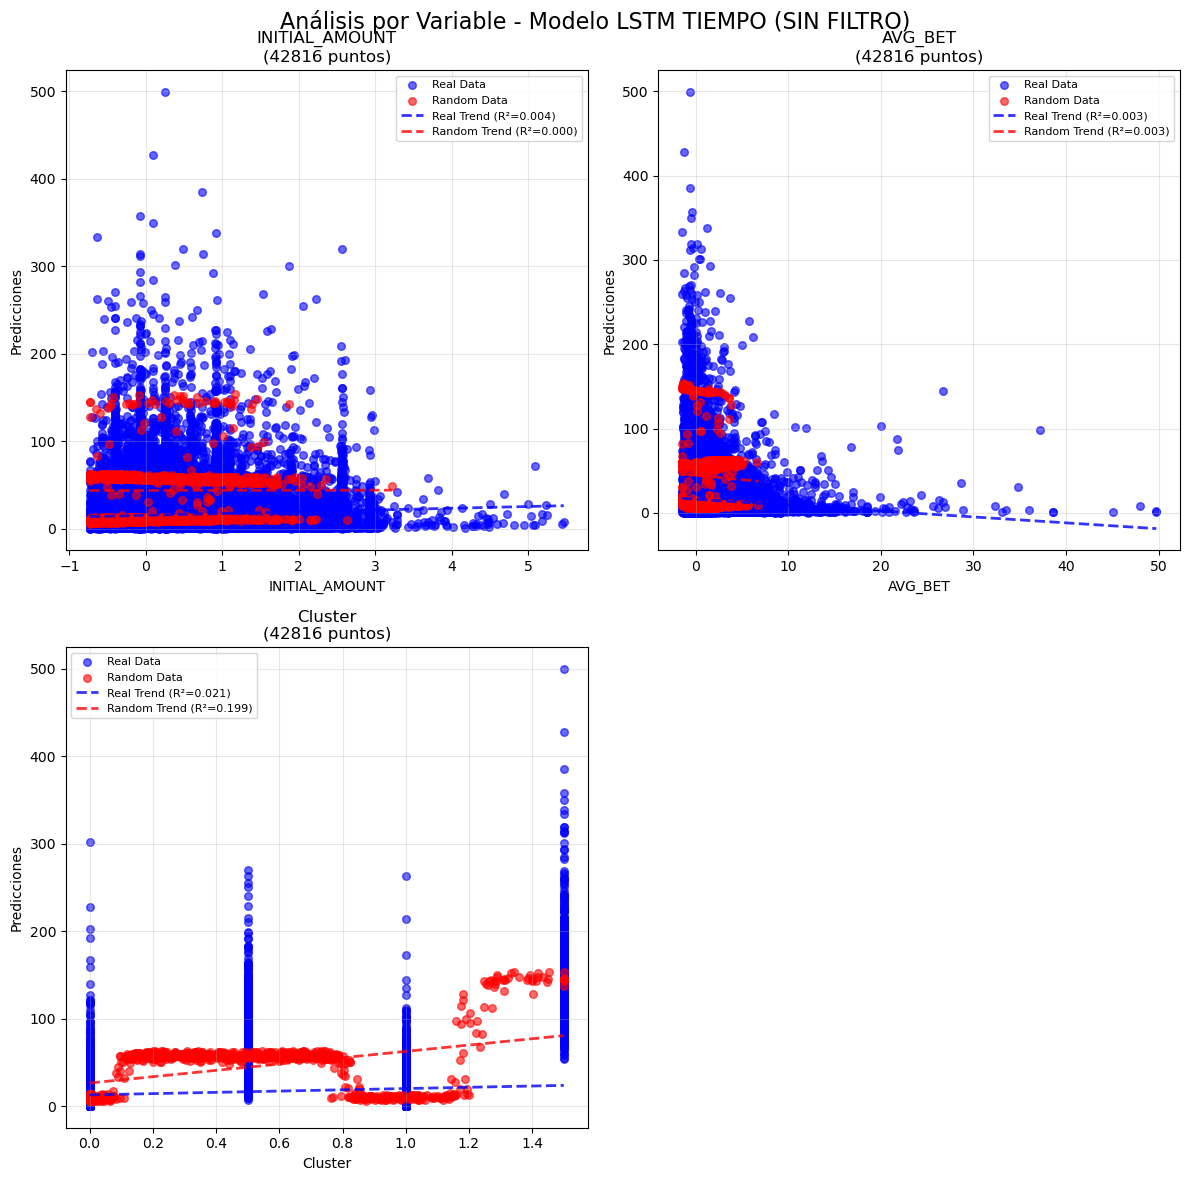

Gráfico guardado: rnn_results/visualizations/tiempo_lstm_individual_features_original.png
Gráficos individuales guardados en: rnn_results/visualizations/tiempo_lstm_individual/

ENTRENANDO MODELO LSTM - BET TOTAL
Epoch 1/100
4182/4182 [==============================] - 40s 8ms/step - loss: 3663275.8884 - mae: 712.9348 - val_loss: 2483827.7500 - val_mae: 526.5991
Epoch 2/100
4182/4182 [==============================] - 27s 6ms/step - loss: 2683162.8268 - mae: 529.2083 - val_loss: 1963477.6250 - val_mae: 505.2981
Epoch 3/100
4182/4182 [==============================] - 28s 7ms/step - loss: 2231881.2525 - mae: 503.2345 - val_loss: 1649198.0000 - val_mae: 471.6123
Epoch 4/100
4182/4182 [==============================] - 30s 7ms/step - loss: 1779441.6768 - mae: 498.3871 - val_loss: 1495567.7500 - val_mae: 459.1672
Epoch 5/100
4182/4182 [==============================] - 29s 7ms/step - loss: 1545141.3590 - mae: 483.0168 - val_loss: 1412809.2500 - val_mae: 458.6366
Epoch 6/100
4182/4182 [====

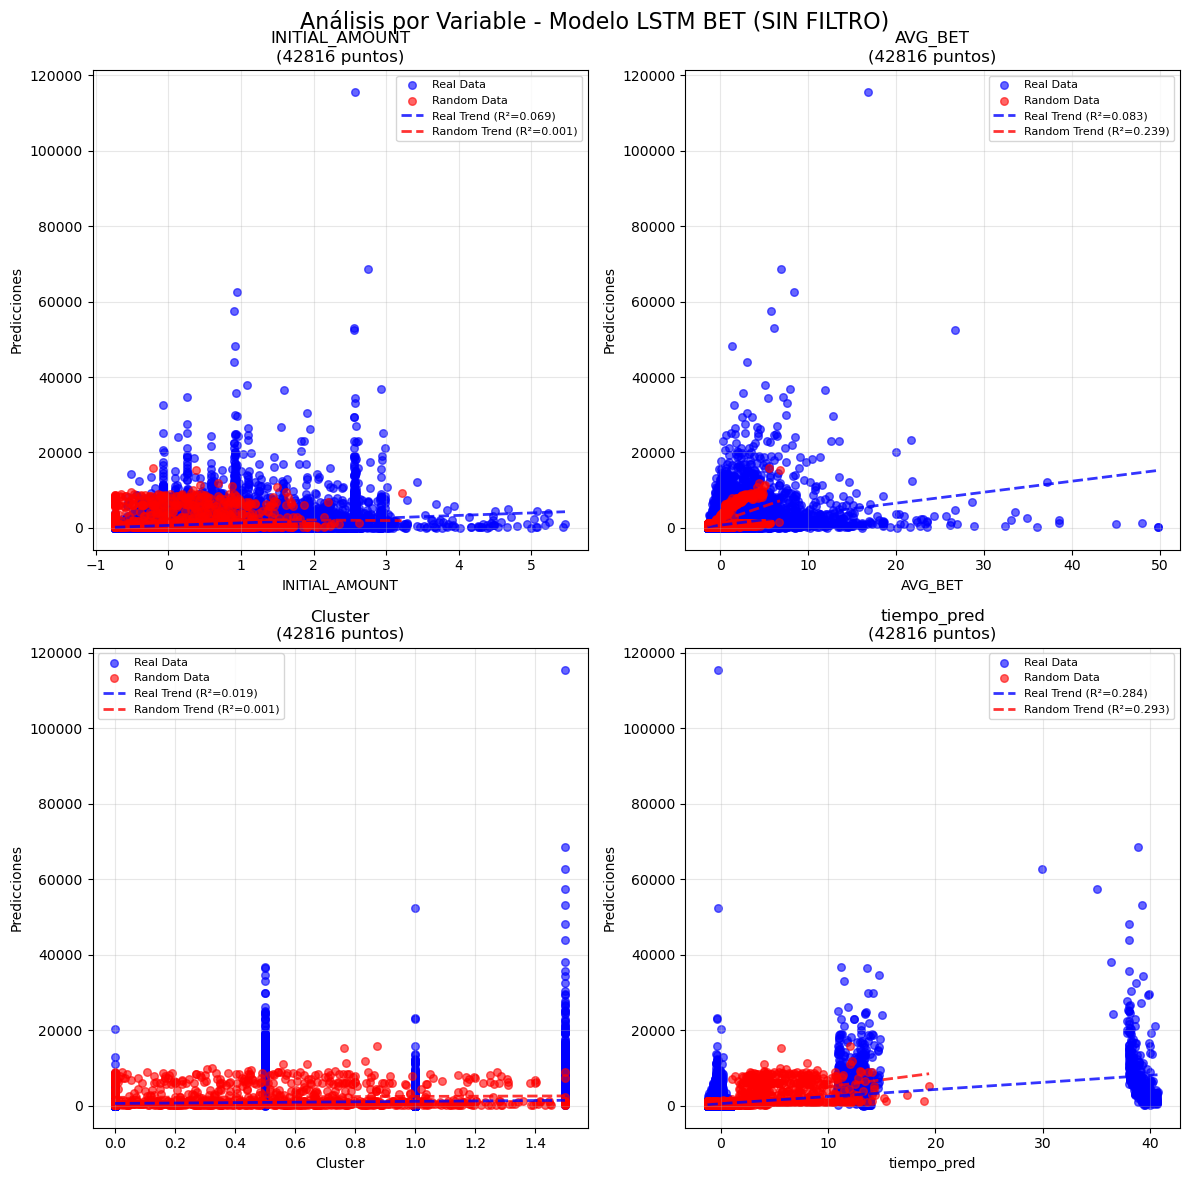

Gráfico guardado: rnn_results/visualizations/bet_lstm_individual_features_original.png
Gráficos individuales guardados en: rnn_results/visualizations/bet_lstm_individual/

ENTRENANDO MODELO LSTM - WIN TOTAL
Epoch 1/100
4182/4182 [==============================] - 84s 18ms/step - loss: 3518633.9492 - mae: 646.8799 - val_loss: 1628819.7500 - val_mae: 537.0678
Epoch 2/100
4182/4182 [==============================] - 74s 18ms/step - loss: 3241307.6303 - mae: 597.0396 - val_loss: 1750926.0000 - val_mae: 529.2173
Epoch 3/100
4182/4182 [==============================] - 71s 17ms/step - loss: 3650655.3211 - mae: 592.4615 - val_loss: 1650409.3750 - val_mae: 556.3094
Epoch 4/100
4182/4182 [==============================] - 71s 17ms/step - loss: 2677405.8151 - mae: 590.6728 - val_loss: 1670076.2500 - val_mae: 536.0315
Epoch 5/100
4182/4182 [==============================] - 71s 17ms/step - loss: 8630059.2926 - mae: 593.5859 - val_loss: 1641535.1250 - val_mae: 544.1282
Epoch 6/100
4182/4182 [=====

: 

In [ ]:
casino_lstm = CasinoLSTMModel()

# Entrenar modelos con visualizaciones
results = casino_lstm.train_and_visualize(
    df_data_general, 
    filter_outliers=False,
    outlier_method='iqr',
    filter_viz_outliers=False,
    n_random_samples=1000,
    output_dir='rnn_results'
)